# Chapter 19    
# Models for Messy Data  
Bill Henderson
 

## Introduction

Real-world data often has complex and messy behavior. In this chapter we explore some methods that can be used to successfully model messy data. In particular, we will explore the following models:     
1. Regresion for **zero-inflated** count data using Poisson regression. Zero inflated data arises when there is a prevelance of observations with zero counts.
2. Regression for **over-dispursed** data using negative binomial generalized linear model regression. Over-dispursed data arrises when there are observations with counts beyond what can be expected from a Poisson distribution.
3. The **influcence of outliers** on the response of linear models. 
4. **Robust regression** models for datasets containing outliers in the observations.

Before conituing with this notebook, exectute the code in the cell below to import the reqquired packages.  

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.discrete.count_model import ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as ss
from statsmodels.graphics.regressionplots import influence_plot, plot_regress_exog
import itertools
import math

def rmse_mae(df, residuals='resids'):
    median = round(df.loc[:,residuals].median(),3)
    mean = round(df.loc[:,residuals].mean(), 3)
    mae = np.absolute(df.loc[:,residuals]).median()
    rmse = np.std(df.loc[:,residuals])
    print('Mean of residuals = ' + str(mean) + '   Median of residuals = ' + str(median))
    print('RMSE = ' + str(round(rmse, 3)) + '  MAE = ' + str(round(mae,3)))
    return rmse, mae

def plot_resid_dist(resids, title1='Histogram of residuals', title2='Q-Q Normal plot of residuals'):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ## Plot a histogram
    sns.histplot(resids, bins=20, kde=True, ax=ax[0])
    ax[0].set_title(title1)
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title(title2)
    plt.show()

def residual_plot(df, predicted='predicted', resids='resids'):
    fig,ax = plt.subplots(figsize=(12,5))
    RMSE = np.std(df.loc[:,resids])
    sns.scatterplot(x=predicted, y=resids, data=df, ax=ax)
    ax.axhline(0.0, color='red', linewidth=1.0)
    ax.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.set_title('PLot of residuals vs. predicted')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residuals')
    plt.show()

## Zero-Inflated Distributiions      

**Zero-inflated data** is a commonly encountered problem, where a large number of observatons have a 0 value. For example, with counts there may be a excess number of observations with a value of 0. There are many real-world examples of zero inflated variables, including the following:     
- The number of goals scored by a soccer player per game.
- The number of items a visitor to an e-commerce website adds to their cart.
- The number of medical patients per month diagnossed with a particular disease.

A [**zero-inflated distribution**](https://en.wikipedia.org/wiki/Zero-inflated_model) is actually a **mixture of of two distributions**, a binomial distribution, and another distribution. Some common examples for counts are:     
1. A)zero-inflated Poisson distribution is a mixture of a binomial distribution and a Poisson distribution.
2. A zero-inflated negative-binomial distribution is a mixture of a binomial distribution and a negative binomial distribution.

The basic algorithm for computing the **probability mass function (PMF)** of a zero-inflated distribution is as follows:  

### Zero-Inflated Poisson Distribution

Let's explore the [**zero-inflated Poisson distribution**](https://en.wikipedia.org/wiki/Zero-inflated_model). The zero-inflated Poisson distribution is a mixture of a binomial distribution and a Poisson distribution. 

Recall that the PMF of the Poisson distribution is:       
\begin{align}    
\mu &= mean\ parameter\ of\ Poisson\ distribution\\   
y_i &= count\ of\ i\\
P(Y=y_i) &= \frac{\mu^{y_i}\ e^{-\mu}}{y_i!}
\end{align}
The Poisson distribution is a mixture of the Poisson distribution and the binomial distribution. The probability mass funciton (PMF) of the zero-inflated distribution is the probability of counts, starting at 0. We can write distribution as:      
\begin{align}
\pi &= binomial\ probability\ of\ success,\ 0 \le \pi \le 1 \\       
\mu &= mean\ parameter\ of\ Poisson\ distribution\\     
y_i &= count\ of\ i\\
P(Y=0) &= \pi + (1 - \pi) e^{-\mu}\\
P(Y=y_i) &= (1 - \pi) \frac{\mu^{y_i}\ e^{-\mu}}{y_i!}
\end{align}

To better understand this relationship, execute the code in the cell below.   

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/744609891.py:29: SyntaxWarning: invalid escape sequence '\p'
  ax_i.set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu_i))
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/744609891.py:29: SyntaxWarning: invalid escape sequence '\m'
  ax_i.set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu_i))


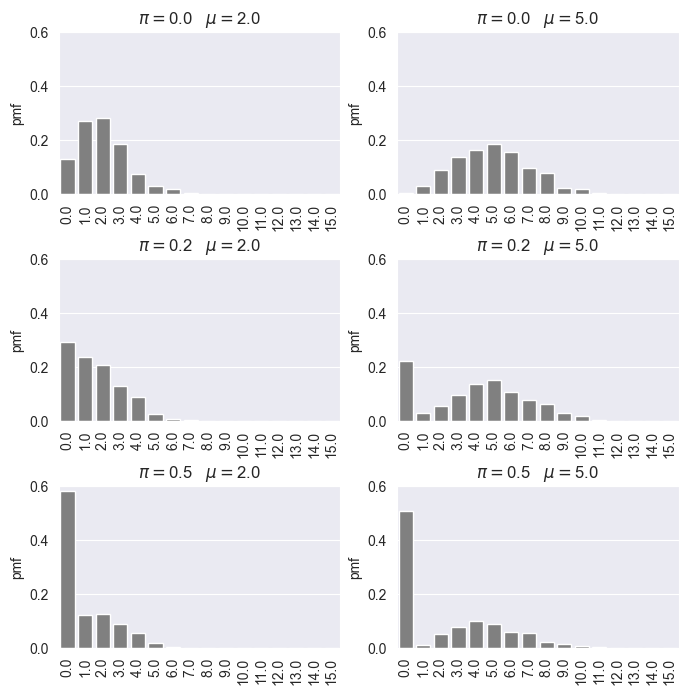

In [118]:
def generate_zero_inflated_poisson(pi, mu, x_max=15, n_samples=1000):
    ## Instantiate data frame for output   
    x=[float(x) for x in range(x_max+1)]
    out_frame = pd.DataFrame({'x':x,'pmf':[0.0]*(x_max+1)})

    ## Compute number of zeros and add to zero cgolumn  
    zeros = np.random.binomial(n_samples, pi)
    out_frame.iloc[0,1]=zeros

    ## Add 1 to counts of outcomes  
    poisson = np.random.poisson(mu, n_samples - zeros)
    for x in poisson:
        if x < x_max +1: out_frame.iloc[x,1] += 1.0

    ## Normalize pmf and return 
    out_frame.iloc[:,1] = out_frame.iloc[:,1]/float(n_samples)
    return out_frame

pis = [0.0, 0.0, 0.2, 0.2, 0.5, 0.5]
mus = [2.0, 5.0, 2.0, 5.0, 2.0, 5.0]
fig, ax = plt.subplots(3,2, figsize=(8,8))
ax = ax.flatten()
fig.subplots_adjust(hspace=0.4)
for pi_i, mu_i, ax_i in zip(pis,mus,ax):   
    sample_frame = generate_zero_inflated_poisson(pi_i, mu_i)
    sns.barplot(data=sample_frame, x='x', y='pmf', color='gray', ax=ax_i)
    ax_i.tick_params(axis='x', rotation=90)
    ax_i.set_ylim(0.0, 0.6)
    ax_i.set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu_i))
    ax_i.set_xlabel('')

Notice the following properties of the zero-inflated Poisson distribution:   
1. The first row of plots shows the Poisson distribution, with mean event counts of $2.0$ and $5.0$, with no zero-inflation.      
2. As the parameter of the binomial distribution, $\pi$, increase in the columns, the number of zeros increases.
3. As the mean parameter, $\mu$, of the Poisson distribution increases the density of larger counts increases.    

### Zero-Inflated Negative Binomial Distribution    

The Poisson distribution can be used to model count and arrival data. However, there are many cases where the event count requires a longer-tailed distribution. The [**negative binomial distribution**](https://en.wikipedia.org/wiki/Negative_binomial_distribution) is just such a distribution. The negative binomial distribution can model **over-dispursion**, or heavy heaby-tailed behavior.  

The familar binomial distritution can be used to model the number of successes in a series of trials. In contrast, the negative binomial distribution models the number of failures, with the sequence ending with a sucess. Further, the negative binomial distribution has two parameters, allowing greater flexability in determining the shape of the distribution.         

The PMF of the negative binomial distribution can be expressed:       
$$f(k) = {k + n - 1 \choose n - 1}\ p^n (1 - p)^k$$      
Where,    
$k =$ number of failures.      
$n = $ number of trials.     
$p =$ probability of success.      

For the analysis we are concerned with, another parameterization of this distribution will be useful. Recall that the mean and variance of the Poisson distribution are identical. In contrast, the negative binomial distribution can be parameterized by a mean and an **over-dispersion parameter, $\alpha$**. This second parameter gives the negaive binomial distribution greater flexibility to model heavy tailed data, compared to the Poisson distribution. The relationship between the mean, $\mu$, and variance, $\sigma^2$ of the negative binomial distribution can be expressed:   
$$\sigma^2 = \mu + \alpha * \mu^2$$     
The over-dispersion coefficient must be $0 \le \alpha$. 

The relationship between the parameters, *p* and *n*, shown above and $\mu$ and $\sigma$ can be expessed:      
\begin{align}
p &= \frac{\mu}{\sigma^2}\\
n &= \frac{\mu^2}{\sigma^2 - \mu}
\end{align}

We can compute the zero-inflated negative binomial distribution as the mixture of the negative binomial distribuiton and a binomial distribution with probability parameter, $0 \le \pi \le 1$:   
\begin{align}
f(K=0) &= \pi + (1-\pi)\ p^n\\
f(K=k) &= (1-\pi){k + n - 1 \choose n - 1}\ p^n (1 - p)^k
\end{align}
In an alterntive parameterization the zero-inflation can be parameterized by a negative value, known as the **inflation constant**.

The foregoing relationships are rather abstract. To get a feel for what this means, execute the code in the cell below.

<>:33: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\m'
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/3948452340.py:33: SyntaxWarning: invalid escape sequence '\p'
  ax_i.set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu_i) + '  alpha = ' + str(alpha_i))
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/3948452340.py:33: SyntaxWarning: invalid escape sequence '\m'
  ax_i.set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu_i) + '  alpha = ' + str(alpha_i))


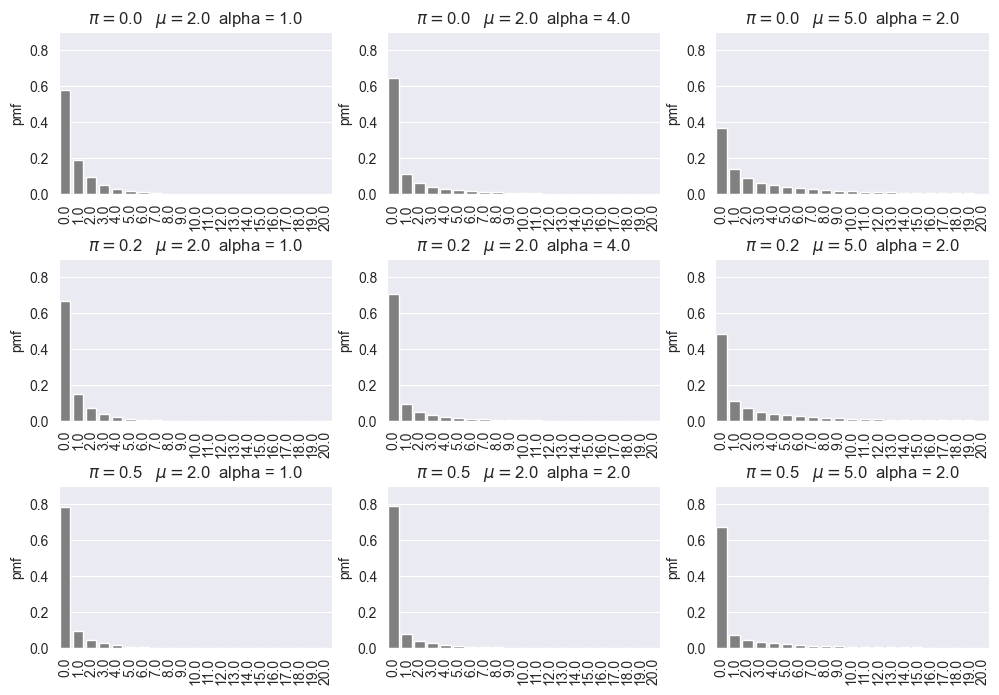

In [119]:
def generate_zero_inflated_nb(pi, mu, alpha, x_max=20, n_samples=1000):
    ## Instantiate data frame for output   
    x=[float(x) for x in range(x_max+1)]
    out_frame = pd.DataFrame({'x':x,'pmf':[0.0]*(x_max+1)})

    ## Compute number of zeros and add to zero cgolumn  
    zeros = np.random.binomial(n_samples, pi)
    out_frame.iloc[0,1]=zeros

    ## Add 1 to counts of outcomes  
    sigma_squared = mu + alpha * mu**2 
    p = mu / sigma_squared
    n = mu**2 / (sigma_squared + mu)
    positive_samples = n_samples - zeros
    negative_binomial = [int(positive_samples * nb) for nb in ss.nbinom(n, p).pmf(x)]
    
    out_frame.iloc[:,1] += negative_binomial

    ## Normalize pmf and return 
    out_frame.iloc[:,1] = out_frame.iloc[:,1]/float(n_samples)
    return out_frame

                       
pis = [0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5]
mus = [2.0, 2.0, 5.0, 2.0, 2.0, 5.0, 2.0, 2.0, 5.0]
alphas = [1.0, 4.0, 2.0, 1.0, 4.0, 2.0, 1.0, 2.0, 2.0,]
fig, ax = plt.subplots(3,3, figsize=(12,8))
ax = ax.flatten()
fig.subplots_adjust(hspace=0.4)
for pi_i, mu_i, alpha_i, ax_i in zip(pis,mus, alphas,ax):   
    sample_frame = generate_zero_inflated_nb(pi_i, mu_i, alpha_i)
    sns.barplot(data=sample_frame, x='x', y='pmf', color='gray', ax=ax_i)
    ax_i.set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu_i) + '  alpha = ' + str(alpha_i))
    ax_i.set_ylim(0.0, 0.9)
    ax_i.set_xlabel('')
    ax_i.tick_params(axis='x', rotation=90)

Examine the plots above, noticing the following:        
- The first row shows plots of the negative binomial distribution, with $\pi=0$.
- As the binomial parameter, $\pi$, increases along the rows of plots the number of cases with 0 counts increases.
- As $\alpha$ increases, the dispursion of the PMF increases.      

### Compairing Zero-Inflated Distributions

Having introduced two different zero-inflated distributions for counts, it is worth investigating how their properties compare. The code in the cell below displays side by side charts of the zero-inflated Poisson (ZIP) distribution and zero-inflated negative binomial (ZINB) distribution, , for different values of $\pi$. Execute this code and examine the results. 

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/1341541225.py:15: SyntaxWarning: invalid escape sequence '\p'
  if j==0: ax[i,j].set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu))
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/1341541225.py:15: SyntaxWarning: invalid escape sequence '\m'
  if j==0: ax[i,j].set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu))
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/1341541225.py:16: SyntaxWarning: invalid escape sequence '\p'
  else: ax[i,j].set_title('$\pi = $' + str(pi_i) + ' 

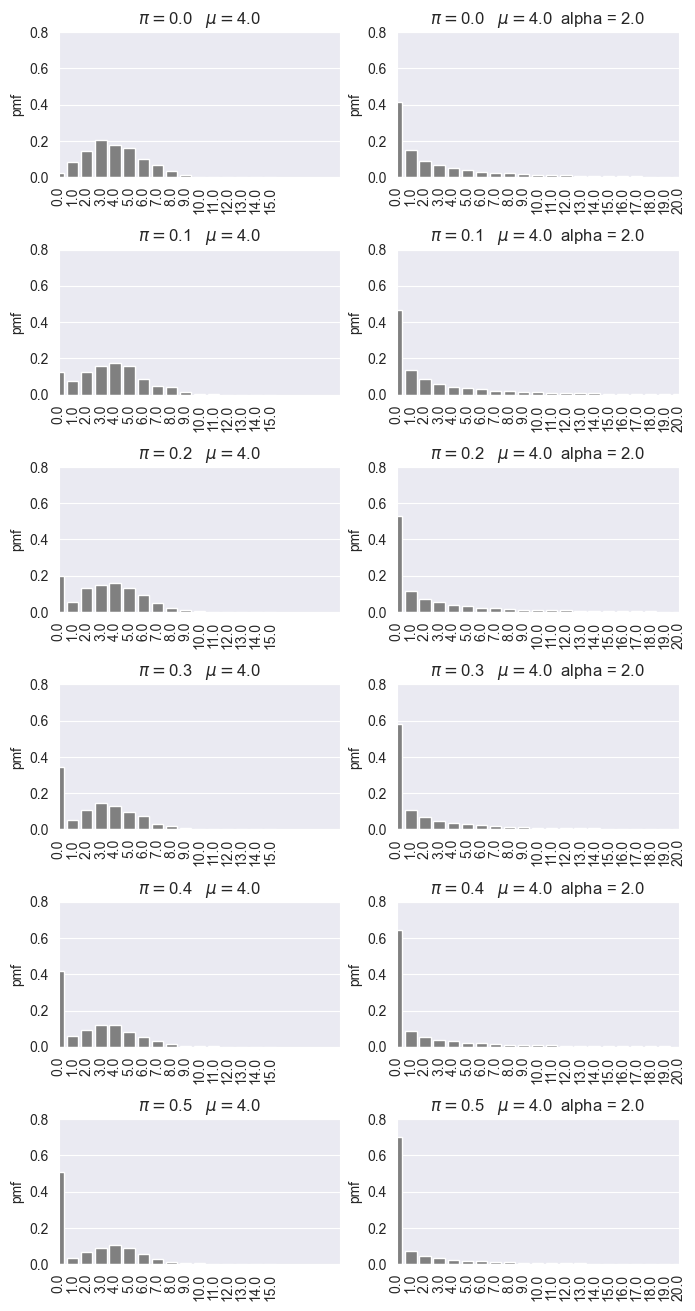

In [120]:
mu=4.0
alpha = 2.0
pis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
fig, ax = plt.subplots(6,2, figsize=(8,16))
fig.subplots_adjust(hspace=0.5)
for i, pi_i in enumerate(pis):   
    sample_frame = generate_zero_inflated_poisson(pi_i, mu)
    sns.barplot(data=sample_frame, x='x', y='pmf', color='gray', ax=ax[i,0])
    sample_frame = generate_zero_inflated_nb(pi_i, mu, alpha)
    sns.barplot(data=sample_frame, x='x', y='pmf', color='gray', ax=ax[i,1])
    for j in range(2):
        ax[i,j].tick_params(axis='x', rotation=90)
        ax[i,j].set_ylim(0.0, 0.8)
        ax[i,j].set_xlim(0.0, 20.0)
        if j==0: ax[i,j].set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu))
        else: ax[i,j].set_title('$\pi = $' + str(pi_i) + '   $\mu = $' + str(mu) + '  alpha = ' + str(alpha))
        ax[i,j].set_xlabel('')

There are two improtant differences between these zero-inflated distributions.     

First, the number of zeros grows much faster for the negative binomial distribution compared to the Poisson distribution as the binomial parameter $\pi$ increases. Notice that the Poisson distribution with $\pi=0.4$ has nearly nearly as high of probability of 0 as the ZINB distribution with $\pi=0.0$. As a result of this behavior difference, we can expect models to estimate much smaller values of the zero-inflation parameter for the ZINB distribution compaired to the ZIP distribution.    

Second, the ZINB distribution has much greater dispersion for a fixed value of $\mu$. This difference in properties can most easily be seen when $\pi=0$. Clearly, changing the value of $\alpha$ will change the dispersion of the ZINB distribution, whereas dispersion is fixed given a value of $\mu$ for the ZIP distribution.   

## Exploring and Preparing the Example Dataset     

To explore zero-inflated and over-dispursed data we will use the [Fish dataset from the UCLA Advanced Research Computing Group](https://stats.oarc.ucla.edu/r/dae/zip/). A download of this data is available on [Kaggle](https://www.kaggle.com/datasets/alincijov/fish-dataset). The data set has 250 observations of groups of people visiting and camping area. Most of these groups are attempting to catch fish during thier visit. However, most of the parties attempting to fish are not successful, with fish counts of zero.      

As a first step, execute the code in the cell below to load this dataset.   

In [121]:
file_path = '../data/fish.csv'
fish = pd.read_csv(file_path)
fish.head(20)

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1
5,0,1,1,4,2,1.394485,-0.707535,0
6,0,1,0,3,1,0.184717,-3.398022,0
7,0,1,0,4,3,2.329107,-5.450902,0
8,1,0,1,3,2,0.188386,-1.527418,0
9,0,1,1,1,0,0.287690,1.393891,1


Examining the head of the data frame, We can see that only some groups actually catch fish. This situation leads to a zero-inflated fish count.   

To explore this problem a bit more, it helps to compute a summary table of how many groups caught any fish out of the total 250 groups. Execute the code in the cell below to see a summary number of groups catching and not catching fish. To get a further feel for the for the distribution of these counts execute the code in the cell below to display a histograme of the counts of fish caught.      

Total groups = 250
Groups fishing = 176
Groups catching fish = 108
Groups with no fish = 142
Groups fishing with no fish = 74


Text(0.5, 0, 'Fish caught')

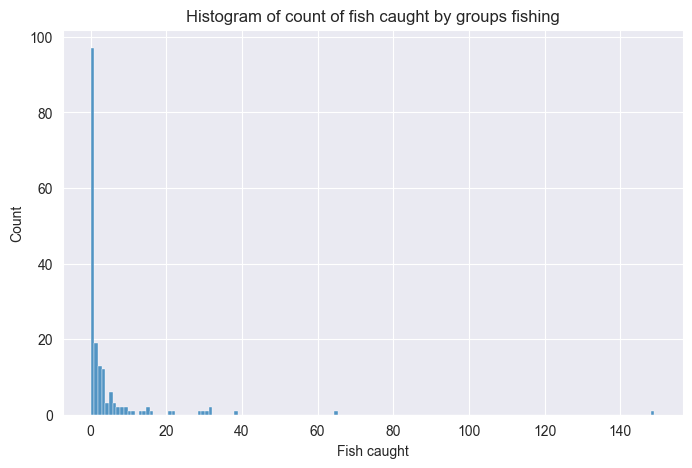

In [122]:
num_groups = fish.shape[0]
fish['caught_fish'] = fish.loc[:,'count'] != 0
num_caught_fish = fish['caught_fish'].sum()
print('Total groups = ' + str(num_groups))
print('Groups fishing = ' + str(fish[fish.loc[:,'nofish']==0].shape[0]))
print('Groups catching fish = ' + str(num_caught_fish))
print('Groups with no fish = ' + str(num_groups - num_caught_fish))
print('Groups fishing with no fish = ' + str(num_groups - fish[fish.loc[:,'nofish']==0].shape[0]))

fish_yesfish = fish[fish.loc[:,'nofish']==0]
#print('Shape of the fish_yesfish data frame = ' + str(fish_yesfish.shape))

cols = ['persons', 'child', 'count']
fig,ax = plt.subplots(figsize=(8,5))
sns.histplot(x='count', data = fish_yesfish, bins=153, ax=ax);
ax.set_title('Histogram of count of fish caught by groups fishing');
ax.set_xlabel('Fish caught')

Notice the large number of zero values. This distribution is zero-inflated. Further, the distribution has a long right tail. It is doubtful that any simple distributional transform will work to standardize this response variable.           

To get a better overall feel for the other variable in this dataset, execute the code in the cell below.

In [123]:
fish.describe()

,nofish,livebait,camper,persons,child,xb,zg,count
count,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000
mean,0.296000,0.864000,0.588000,2.52800,0.684000,0.973796,0.252323,3.296000
std,0.457407,0.343476,0.493182,1.11273,0.850315,1.440277,2.102391,11.635028
min,0.000000,0.000000,0.000000,1.00000,0.000000,-3.275050,-5.625944,0.000000
25%,0.000000,1.000000,0.000000,2.00000,0.000000,0.008267,-1.252724,0.000000
50%,0.000000,1.000000,1.000000,2.00000,0.000000,0.954550,0.605079,0.000000
75%,1.000000,1.000000,1.000000,4.00000,1.000000,1.963855,1.993237,2.000000
max,1.000000,1.000000,1.000000,4.00000,3.000000,5.352674,4.263185,149.000000


Notice the range of the variables.      
1. The 'nofish', 'livebait' and 'camper' variables are binary. Nearly 30% of the parties are not fishing, likely contributing to the zero-inflation.     
2. The 'persons' variable ranges from 1 to a maximum party size of 4.    
3. The 'child' variable ranges from 0, no childern, to 3, presumable 1 adult with 3 childern.      
4. We will ignore the `xb` and `zg` variables.
5. The counts range from 0 to a maximum of 149. It appears that there are likely to be outliers or exagerated counts of fish counts.
   
We will clean the outliers since there are only 2 counts greater than 30. Execute the code in the cell below to filter the outliers.   

In [124]:
fish = fish[fish.loc[:,'count'] < 30]
fish_yesfish = fish[fish.loc[:,'nofish']==0]
fish.shape

(243, 9)

With the outliers removed, we are ready to do some detailed exporatory data analysis (EDA).     

Execute the cod ein the cell below to display histograms of two key variables.   

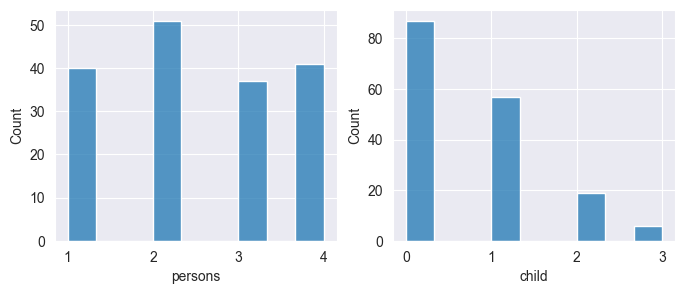

In [125]:
cols = ['persons', 'child']
fig,ax = plt.subplots(1, 2, figsize=(8,3))
for i, col in enumerate(cols): 
    sns.histplot(x=col, data = fish_yesfish, ax=ax[i])

You can see that the number of pepople in the groups is realative uniform. Whereas, there are declining numbers of groups with increasing numbers of childern. As noted earlier, there must be at least one adult with groups containing childern.   

Next, display the distribution of fish caught by bait type and camper or not-camper

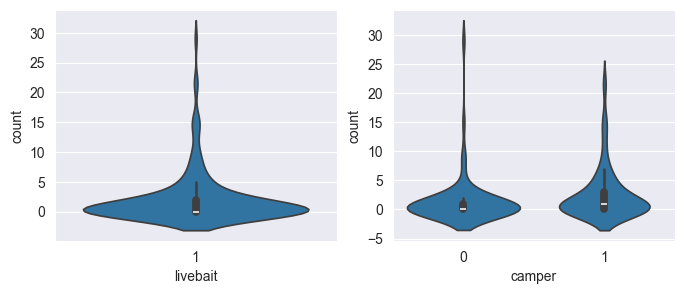

In [126]:
cols = ['livebait', 'camper']
fig,ax = plt.subplots(1, 2, figsize=(8,3))
for i, col in enumerate(cols): 
    sns.violinplot(x=col, y='count', data = fish_yesfish, ax=ax[i])

Aparently, all groups fishing use live bait. We can eliminate this variable from our analysis.       

The plot on the right shows that on average parties catch more fish when camping. However, there are outliers of large numbers of fish caught for non-camping party.     

This dataset is inherently multi-variate and needs to be explored in a multidimensional manner. In this case we will seek to understand the complex relationshops between the variables. In this case we will use facet-plotting to create multi-dimensionsal views.      

Now, execute the code in the cell below to display a facet plot of histograms of fish caught conditioned by persons and childern.     

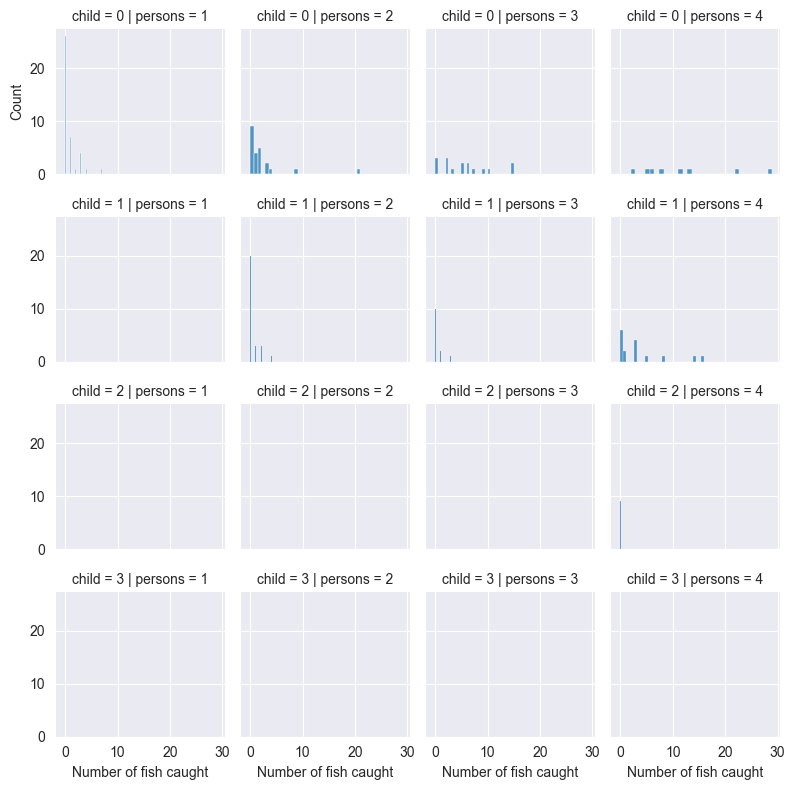

In [127]:
g = sns.FacetGrid(fish_yesfish, row='child', col="persons", height=2, aspect=1.0); 
g = g.map(sns.histplot, 'count', bins=30) 
for ax in g.axes.flatten(): 
    ax.set_xlabel('Number of fish caught')

Notie the following about the relationships visible in the plot:     
1. There are no obserbvations where the number of childern is greater than or equal to the number of persons.          
2. The zero-inflation of the counts is evident.
3. The more childern the fewer fish caught.
4. Larger parties catch more fish on average.

Next, execute the code in the cell below to display histgrams of fish caught conditioned on number of people in the party and if the party is camping or not.  

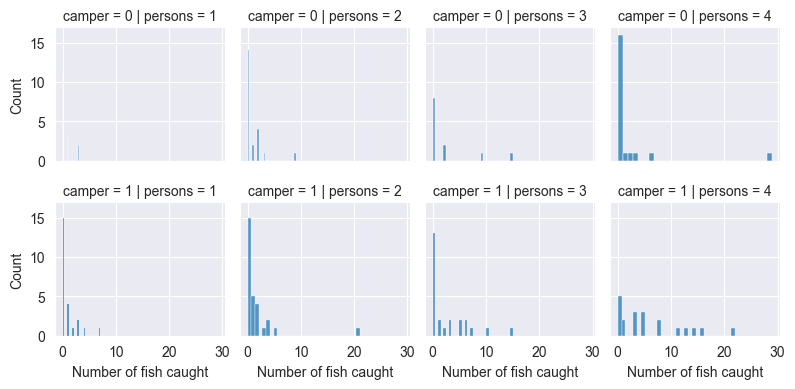

In [128]:
g = sns.FacetGrid(fish_yesfish, row='camper', col="persons", height=2, aspect=1.0);
g = g.map(sns.histplot, 'count', bins=30) 
for ax in g.axes.flatten():
    ax.set_xlabel('Number of fish caught')

Notice the     
1. The zero-inflation of the counts is evident in these plots.
2. On average, campers catch more fish than non-campers. But, there are some clear outliers for non-campers, particularly for large parties.

Finally, to examine more details of the relationship between fish caught vs. the number of people and number of childern in the parties and if the party camped or not, execute the code in the cell below.   

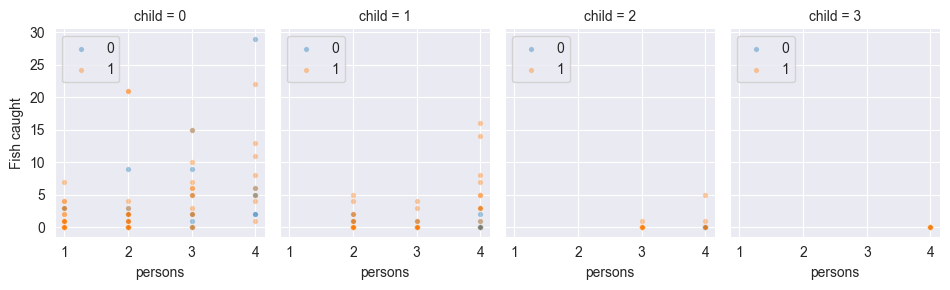

In [129]:
def plot_fish(df, x, c1, c2, response, legend=True):     
    g = sns.FacetGrid(df, col=c1, hue=c2, height=3, aspect=0.8);
    g = g.map(sns.scatterplot, x, response, s=15, alpha=0.4) 
    for ax in g.axes.flatten():
        ax.set_ylabel('Fish caught')
        if legend==True: ax.legend(loc="upper left")
    return g

plot_fish(fish, 'persons', 'child', 'camper', 'count');

Once agan it is clear that parties with more adults and fewer childern catch more fish. Further, there clear outliers, for both campers and non-campers. For example, notice that there is a party of 2 people with no childern that caught over 20 fish, and a the highest number of fish caught was a party of 4 with no childern that were non-campers.      

So far, we have looked at multi-dimensional views where each variable is treated independently. But, it is common in complex data to have non-linear dependencies between variables. Often these non-linear dependencies can be modeled as **interaction terms**. We can explore this posibility using a common approach, an [**interaction plot**](https://statisticsbyjim.com/regression/interaction-effects/). The interactiion plot displays the mean of the response variable for different levels of independent variables. If the dependency between the variables is approximately colinear, there is no interaction. If the mean response diverges between the levels of the variables, an interaction can be inferred.    

The code in the cell below displays interaction plots for three vaiable pairs.       
1. Number of people n a party and if the party is camping.
2. Number of people in the party and the number of childern in the party.    
3. Number of childern in the party abd if the party camped or not.     
Execute the code.        

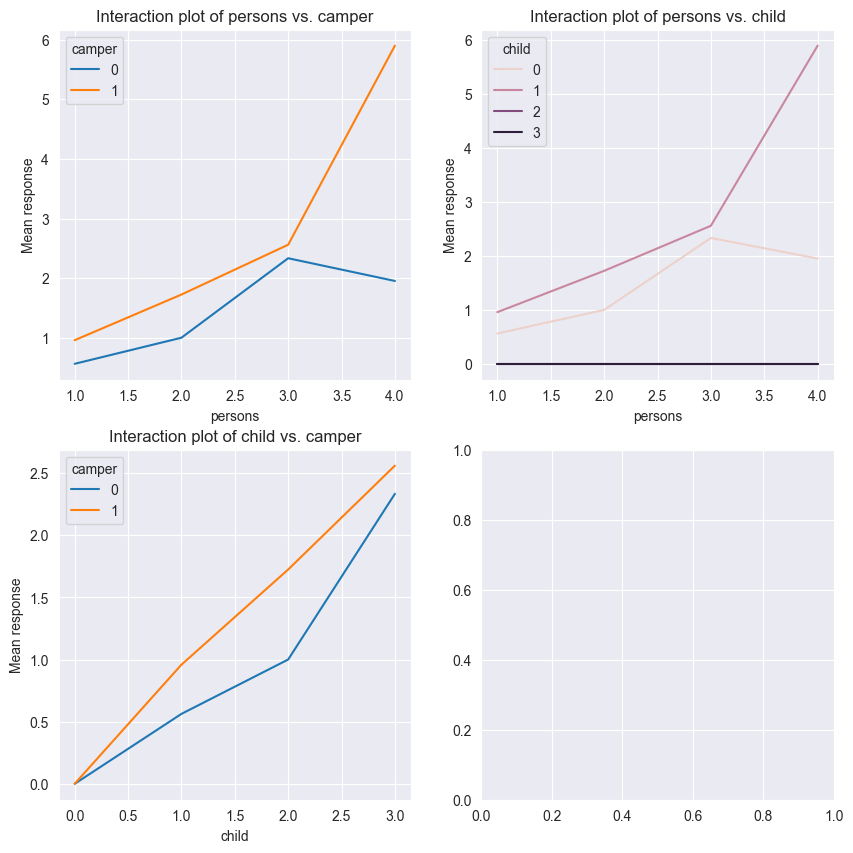

In [130]:
def plot_interaction(df, x, trace, response, ax):
    """Function to display an interaction plot using hree the 
    meam of the respose
    df - dataframe of observations    
    x - the factor on the x axis on the plot
    trace - another factor variable    
    ax - a Matplotlib axis object"""
    
    ## Find the unique levels of the factors and the combinatuiions
    x_levels = df[x].unique()
    trace_levels = df[trace].unique()
    combinations = list(itertools.product(x_levels, trace_levels))

    ## Compute the response leves
    response_levels = [df[np.logical_and(fish_yesfish['camper']==comb[1], fish_yesfish['persons']==comb[0])].loc[:,'count'].mean() for comb in combinations]
    response_levels = [0.0 if  math.isnan(x) else x for x in response_levels]

    ## Create a data frame
    out_frame = pd.DataFrame.from_records(combinations, columns=[x,trace])
    out_frame['response'] = response_levels
    
    ## Now create the plot
    sns.lineplot(data=out_frame, x=x, y="response", hue=trace, markers=True, ax=ax);
    ax.set_ylabel('Mean response');
    ax.set_title('Interaction plot of ' + x + ' vs. ' + trace);

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
plot_interaction(fish_yesfish, x='persons', trace='camper', response='count', ax=ax[0])
plot_interaction(fish_yesfish, x='persons', trace='child', response='count', ax=ax[1])
plot_interaction(fish_yesfish, x='child', trace='camper', response='count', ax=ax[2])

Examine these plots and notice the following:      
1. The plot of fish caught vs. number of people in the party are colinear for campers and non-campers, except for parties of 4. This divergence indicates a possible interaciton between number of people and camping.
2. The polt of fish caught vs. people in the party shows muliple divergences between parties with different numbers of childern. All parties with 2 or 3 childern catch no fish on average. Parties with 0 and 1 child are colinear, except for parties of 4 which diverge. These interactions show a complex patern.
3. The plot of fish caught vs. number of childern in the party shows colinearity for campers vs. non-campers. There is no evidence of interaction.

To summarize there this dataset has complex interactions and significant over-dispersion. Given this complexities and the limited number of observations, we must expect that any model will struggle to incorporate all of this complexity.     

## Zero-Inflated Poisson Regression  

Now that we have explored the dataset a bit, we will now attempt to create a model. Possion regression is a reasonable choice, given that the response variable is discrete counts. However, the model must account for the significant zero-inflation observed in the response variable. Therefore, for a first attempt to model these data we will use a zero-inflated Poisson regression.   

All of the independent variables have the same order of magnitude so, we will not perform scaling. However, we will zerp center the independent variables so that the intercept and other coefficients are interpretable. Execute the code in the cell below to center the variables.      

In [131]:
for col in ['persons','child','nofish']:
    mean = fish.loc[:,col].mean()
    fish.loc[:,col] = fish.loc[:,col] - mean
    if(col=='persons'): persons_mean = mean

/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/2951237020.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.49382716 -1.49382716 -1.49382716 -0.49382716 -1.49382716  1.50617284
  0.50617284  1.50617284  0.50617284 -1.49382716  1.50617284  0.50617284
  0.50617284  0.50617284 -1.49382716 -1.49382716  1.50617284  0.50617284
 -0.49382716  0.50617284  1.50617284  1.50617284 -0.49382716 -0.49382716
 -0.49382716  1.50617284 -0.49382716 -1.49382716  1.50617284 -1.49382716
  0.50617284  1.50617284  1.50617284 -1.49382716 -0.49382716 -0.49382716
  1.50617284  0.50617284  1.50617284 -1.49382716  0.50617284  1.50617284
  1.50617284 -1.49382716 -0.49382716 -1.49382716 -0.49382716 -0.49382716
 -0.49382716 -0.49382716  1.50617284 -0.49382716  0.50617284 -1.49382716
 -1.49382716 -1.49382716  1.50617284 -1.49382716 -0.49382716 -0.49382716
 -0.49382716  1.50617284 -1.49382716 -1.49382716  0.50617284 -1.493827

As a first model, we will use the [ZeroInflatedPoisson model from Statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.count_model.ZeroInflatedPoisson.html) with a basic formula using three variables. Execute the code in the cell below to fit the model and print a summary.   

In [132]:
formula = 'count ~ -1 + persons + child + camper' 
zero_inflated_possion_model = ZeroInflatedPoisson.from_formula(formula=formula, data=fish).fit()
zero_inflated_possion_model.summary()

Optimization terminated successfully.
         Current function value: 1.862239
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                   count   No. Observations:                  243
Model:             ZeroInflatedPoisson   Df Residuals:                      240
Method:                            MLE   Df Model:                            2
Date:                 Mon, 11 Nov 2024   Pseudo R-squ.:                  0.1366
Time:                         17:54:31   Log-Likelihood:                -452.52
converged:                        True   LL-Null:                       -524.15
Covariance Type:             nonrobust   LLR p-value:                 7.852e-32
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4354      0.183     -2.383      0.017      -0.793      -0.077
persons           0.6253      0.050     12.594      0.000       0.528       0.723
child            -1.2491      0.095    -13.113      0.000      -1.436      -1.062
camper            0.7420      0.081      9.179      0.000       0.584       0.900
=================================================================================
"""

> **Note:** how can we interpret the negative value of the `inflate_const`. This coefficeint is on a log scale.      
> $$\pi = exp(inflate\_const)$$    
> The binomial parameter must be within the range $0 \le \pi \le 1$. Thus, the `inflate_const` must be in the range $-\inf \le inflate\_const \le 0$. The more negative the coefficient the smaller the value of $\pi$.
>
> In this case, we can interpret the value of the `inflate_const` in the summary table in terms of the binomial parameter value, $exp(-0.44) = 0.64$.

To compute and display summary metrics and residual plots for the models execute the code in the cell below.   

Mean of residuals = 0.405   Median of residuals = -0.345
RMSE = 3.402  MAE = 0.756


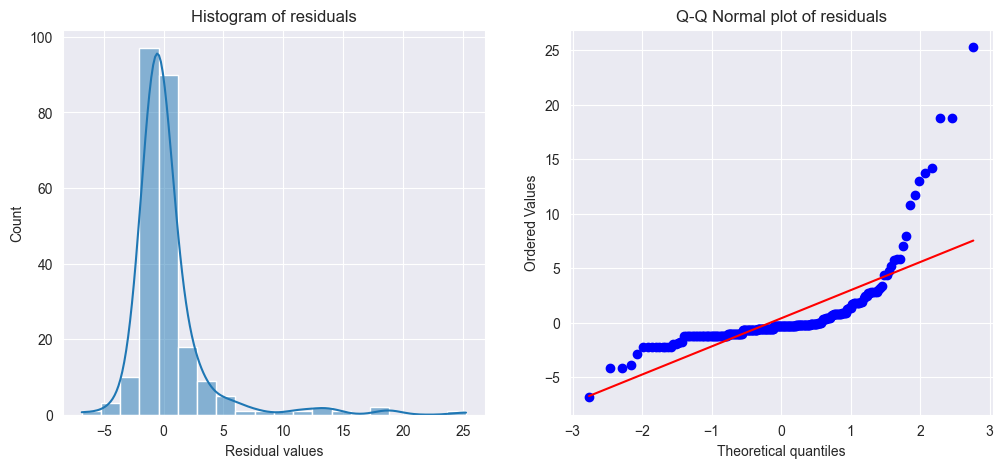

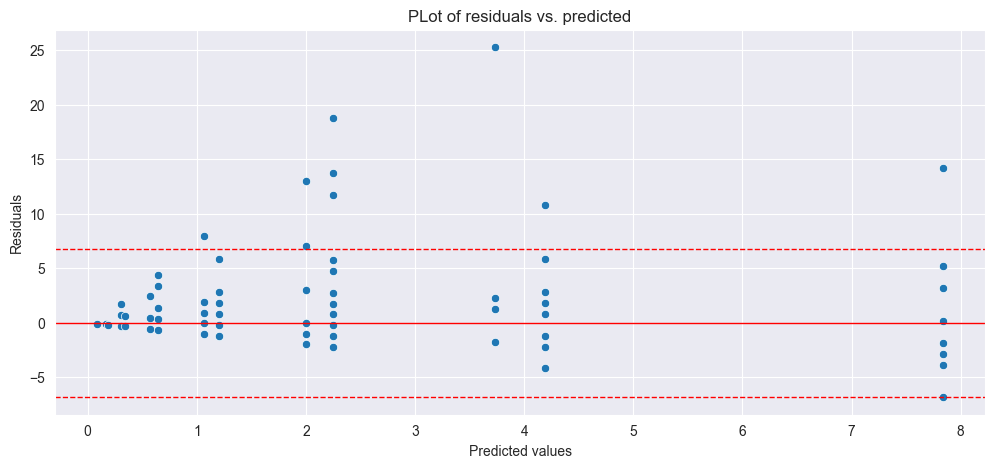

In [133]:
fish.loc[:,'predicted'] = zero_inflated_possion_model.predict(fish)
fish.loc[:,'resids'] = fish.loc[:,'count'].sub(fish.loc[:,'predicted'])

_=rmse_mae(fish)
plot_resid_dist(fish.loc[:,'resids'])
residual_plot(fish)

Notice that the residuals for the zero-inflated Poisson regression appear to be quite heteroscedastic. But, keep in mind that the residuals for a zero-inflated Poisson regression are not expected to be Normal, given the response of the GLM. It is clear that we need a transformation of the residuals to make these plots more interpretable.      

A common approach to transform the residuals for a GLM is to apply the [**Pearson residual adjustment**](https://www.statology.org/pearson-residuals/). This adjustment transforms the distribution of the residuals to $\chi^2$. For our case, we will use a basic form of this transformation:      

$$r_i^{Pear} = \frac{y - \hat{y}}{\sqrt{\hat{y}}}$$

The code 

Mean of residuals = 0.405   Median of residuals = -0.345
RMSE = 3.402  MAE = 0.756


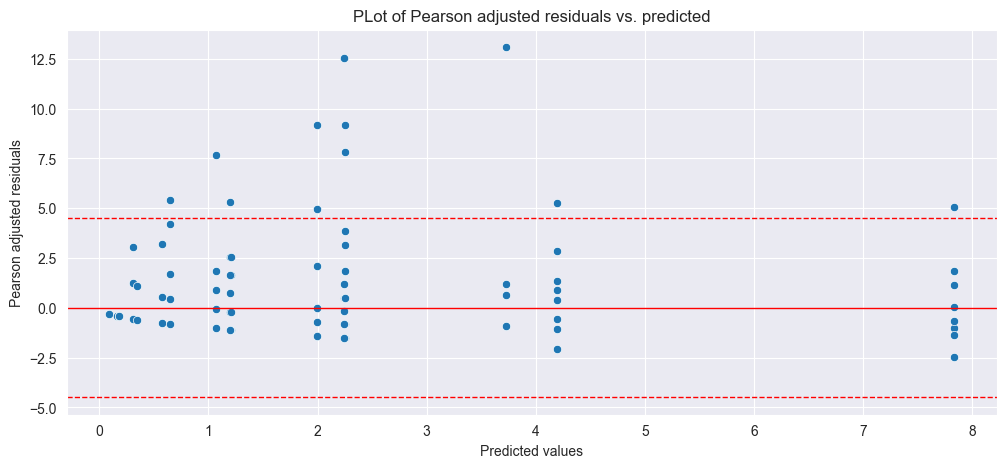

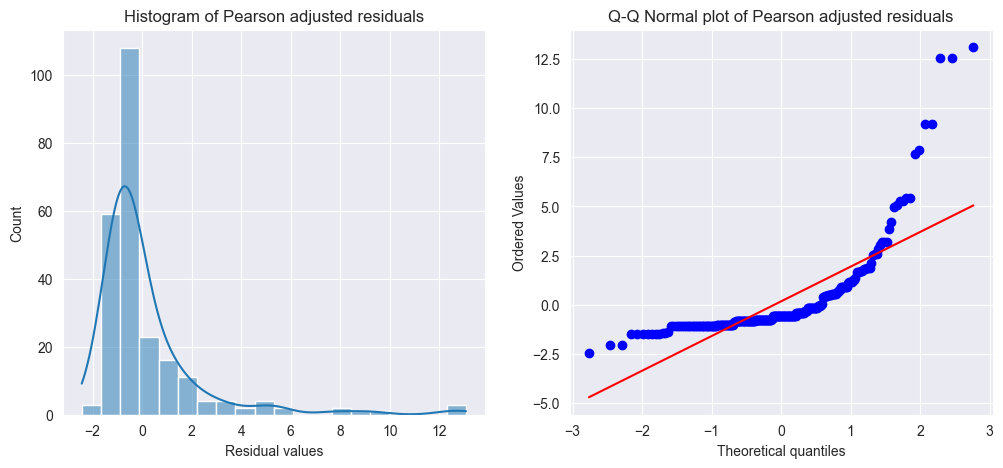

In [134]:
def pearson_residual_plot(df, predicted='predicted', response='count'):
    df['resids'] =  np.divide(df.loc[:,response].sub(fish.loc[:,predicted]), np.sqrt(fish.loc[:,predicted]))
    fig,ax = plt.subplots(figsize=(12,5))
    RMSE = np.std(df.loc[:,'resids'])
    sns.scatterplot(x=predicted, y='resids', data=df, ax=ax)
    ax.axhline(0.0, color='red', linewidth=1.0)
    ax.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.set_title('PLot of Pearson adjusted residuals vs. predicted')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Pearson adjusted residuals')
    plot_resid_dist(fish.loc[:,'resids'], title1='Histogram of Pearson adjusted residuals', title2='Q-Q Normal plot of Pearson adjusted residuals')
    plt.show()

fish.loc[:,'predicted'] = zero_inflated_possion_model.predict(fish)

_=rmse_mae(fish)
pearson_residual_plot(fish)

While far from ideal, these residuals look more like what we expect.  

> **Exercise 25-1:** Examine the summary of the model and the residual plots and answer the following questions:      
> 1. Has the model explained much of the variance of the data?      
> 2. Is there evidence of the model being overfit, and if so what?      
> 3. Is the zero inflation statistically significant and why?   
> 4. Examine residual plots and the mean and median of the residuals. Keep in mind that if is impossible for Poisson regression to predict negative values. From these residuals, what can you say about the fit of this model and the skew of the residuals?           

> **Answers:**    
> 1. It seems our model did a decent job explaining the variance of the data. Most of the coefficients have very low p values, minus the $inflate\_const$, and none of the confidence intervals include zero. Our residual measure are also fairly low after the Pearson adjustment.          
> 2. There is some evidence of overfit, especially in the $inflate\_const$ standard error being relatively high, a fair number of high residuals, and significant deviation off the normal line in the QQ plot.               
> 3. Yes, the zero inflation is stastically significant since the $inflate\_const$ p value is less than 0.05 and its confidence interval doesn't include zero.            
> 4. The fit of the model has some problems due to skew in both directions which is clear from the residual and QQ plots. Having a negative median or negative residuals itself shows there's some negative skew, as well as the curve away from the norm on the QQ plot. This is happening on the positive side as well, but it's most stark in the negative direction due to properties of the Poisson distribution.       

## Modeling with Over-Dispersion    

From the results of the zero-inflated Poisson model, it is clear that that we should search for another model with a better fit. To address the over-dispersion of the response variable we will try a zero-inflated negative binomial distribution regression. The negative binomial distribution explicity models over-disperion, but adds one extra parameter that must be estimated. With a fairly small dataset, estiamting an extra parameter can prove problematic.         

There are a number of models one could try at this point. You can see a sample of the possibilities of model formulas in the code cell below. Only a simple model is not commented out. Other models were either overfit, or more complex and with on better fit. Therefore, we will proceed with the simple model.          

Execute the code in the cell below to fit the model and display the summary.  

**Note:** Yoy may see a warning about inverting the Hessian. For this model it is safe to ignore this warning. 

In [135]:
#formula = 'count ~ persons + child + camper + nofish'  es the 
#formula = 'count ~ persons + child + camper + livebait'  
#formula = 'count ~ persons + child + camper'
formula = 'count ~ -1 + persons + child + camper'   
#formula = 'count ~ persons + child + nofish'   
#formula = 'count ~ persons + np.sqrt(child) + camper'   
#formula = 'count ~ persons + child + camper + persons:child'  
#formula = 'count ~ persons + persons:child + persons:camper + nofish' 
#formula = 'count ~ persons + persons:child + nofish + camper' 
#formula = 'count ~ persons + persons:child + camper' 
#formula = 'count ~ -1 + persons:child + persons:camper' 
#formula = 'count ~ persons:child + camper + nofish' 
#formula = 'count ~ np.square(persons) + np.sqrt(child) + camper'   
zero_inflated_negative_binomial_model = ZeroInflatedNegativeBinomialP.from_formula(formula=formula, data=fish).fit(maxiter=100, cov_type='HC1')
zero_inflated_negative_binomial_model.summary()

Optimization terminated successfully.
         Current function value: 1.457375
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24


/Users/hendwi1/Documents/workspace/harvard/CSCI-E-83/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/hendwi1/Documents/workspace/harvard/CSCI-E-83/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                             count   No. Observations:                  243
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      240
Method:                                      MLE   Df Model:                            2
Date:                           Mon, 11 Nov 2024   Pseudo R-squ.:                  0.1118
Time:                                   17:54:32   Log-Likelihood:                -354.14
converged:                                  True   LL-Null:                       -398.72
Covariance Type:                             HC1   LLR p-value:                 4.352e-20
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -2.0208      0.851     -2.374      0.018      -3.689      -0.352
persons           0.8152      0.106      7.718      0.000       0.608       1.022
child            -1.5326      0.172     -8.924      0.000      -1.869      -1.196
camper            0.4319      0.162      2.671      0.008       0.115       0.749
alpha             1.3576      0.324      4.191      0.000       0.723       1.993
=================================================================================
"""

> *Note:* There is likely to be a warning about a failure to invert the Hessian. For the purpose of our analysis here, this problem will likely not matter since we are not using the estimate of the Hessian for our interpretation of the model.

We can interpret the inflation coefficient as follows.  

$$\pi = exp(-2.0) = .14$$

As is expected from the properties of the distributions, a much lower inflation coefficeint is expected for the ZINB distribuiton with over-dispersion parameter, $\alpha=1.4$, compared to the ZIP distribution.   

Next, the issue of model fit must be addressed. Execute the code in the cell below to display summary fit metrics and residual plots.      

Mean of residuals = -0.226   Median of residuals = -0.574
RMSE = 3.408  MAE = 0.824


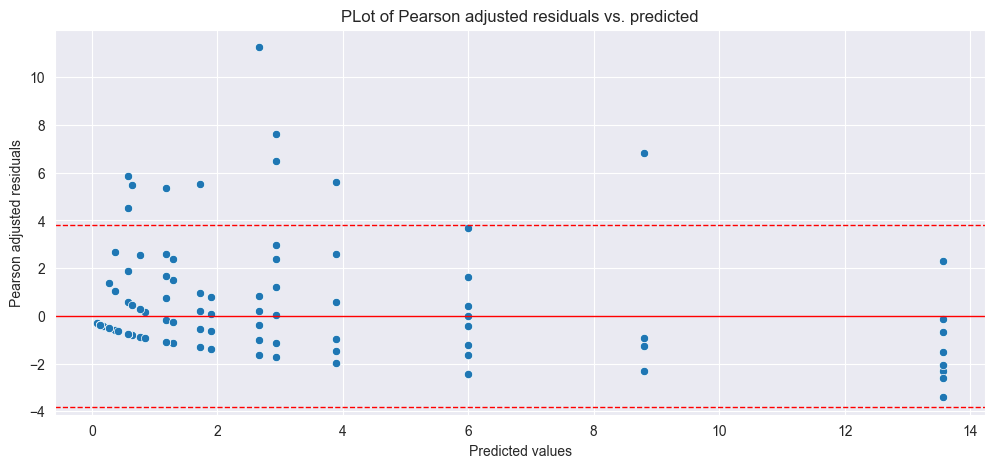

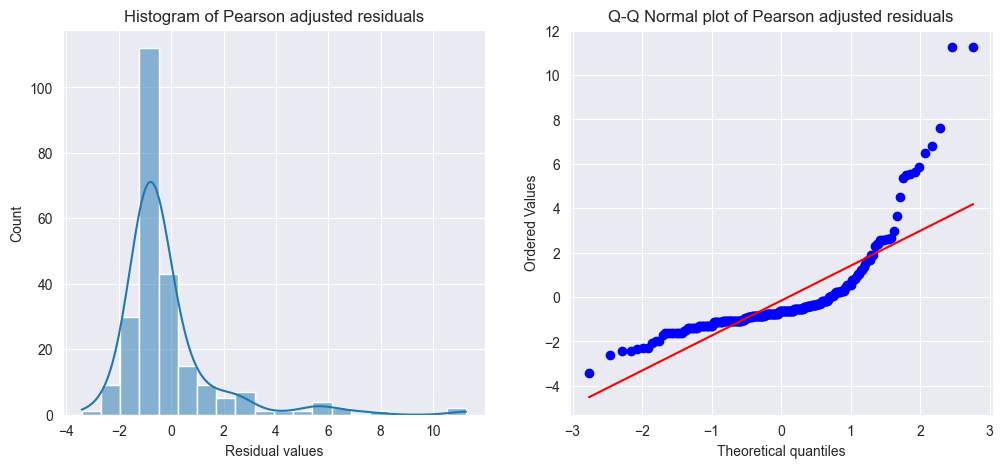

In [136]:
fish.loc[:,'predicted'] = zero_inflated_negative_binomial_model.predict(fish)
fish.loc[:,'resids'] = fish.loc[:,'count'].sub(fish.loc[:,'predicted'])
fish['predicted']

_=rmse_mae(fish)
pearson_residual_plot(fish)

> **Exercise 25-2:** Examine the model summary, performance metrics and residual plots for the zero-inflated negative binomial regression and compare them to the zero-inflated Poisson regression and answer the following questions:
> 1. Is the model over fit or not and why?
> 2. Examine residual plots and the mean and median of the residuals. Keep in mind that if is impossible for negative binomial regression to predict negative values. From these residuals, what can you say about the fit of this model?  How do these residuals compare to the zero-inflated Poisson model?
> 3. Does the model indicate there is statistically significant zero-inflation, and if so what is the evidence?        
> 4. Does the model indicate there is statistically significant over-dispersion, and if so what is the evidence?    
> 5. Compare the performance metrics btween the two models. What might the differences tell you about the differences of the two model fits if any? Given that the residuals have extreme values, do you think the MAE or RMSE is more reliable measure of model fit?
> 6. Examine the model coefficients and answer these questions:
>     - a. If you were planning to fish by yourself and another person joins you, how many additional fish on average would you expect to catch.
>     - b. If you are fishing, how many fewer fish would you expect to catch if a child is added to your party.
>     - c. If your party camps, how many more fish on average would your party expect to catch?     

> **Answers:**
> 1. There are still some high residuals and a fair amount of deviation off the norm for the QQ plot, as well as a low $pseudo-R^2$ with better but poor homoscedacity. The model is not well fit, but better than before.             
> 2. It appears the counts of the negative residuals have decrease a good amount, but there are still some there. As we are using a ZINB model, there should be no negative values, the mean and median of the residuals should not be negative either. With the number of negative residuals as well as the mean and median being negative, we're getting negative count values from the model. Though, the residual counts look better, our residual mean went negative this time as well, so we're getting a bit of a middling response. Hard to say this is better, just different.           
> 3.  It seems our zero inflation has decreased quite a bit observing the value historgram, but our $inflate\_const$ magnitude increased a fair amount along with its standard deviation. It appears our zero-inflation from before slipped into the negative.         
> 4. Our confidence intervals seems to have increase some, giving evidence of increased over dispersion, as well as our error metrics increasing in magnitude. It would see we do have some over-disperson.                 
> 5. We do see some increase in the error metrics from the previous model, but as stated, there are some significant outlier residuals which skew these metrics a fair amount. These metrics would be far more dependable if the outliers were removed, as it stands, they seem to be a better measure of the outliers.              
> 6. 
>    a. If one more person joined to fish, we'd catch about 0.8 more fish. 
>    b. If a child joined, I'd expect to catch 1.5 fish less.
>    c. If camping, I'd expect to catch 0.4 more fish. 
     

## Bootstrap Resampling the Model

A question we should ask is what is the distribution of the model parameters and how much can we rely on the estimates of the model parameters and the predictions made by the model. To answer this question, we can bootstrap resample the zero-inflated negative binomial regression model. The code in the cell below perform this bootstrap resampling of the model. Execute the code and examine the results.          

Parameter = inflate_const
Mean = -2.8183688261373545
Upper confidence interval = -0.8694162221084933
Lower confidence interval = -14.41883684460794


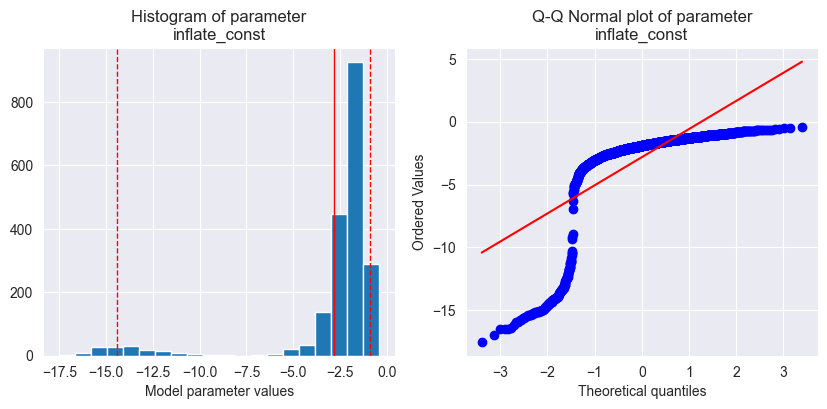

Parameter = persons
Mean = 0.8119355693857105
Upper confidence interval = 1.0303480149556807
Lower confidence interval = 0.5898028584381617


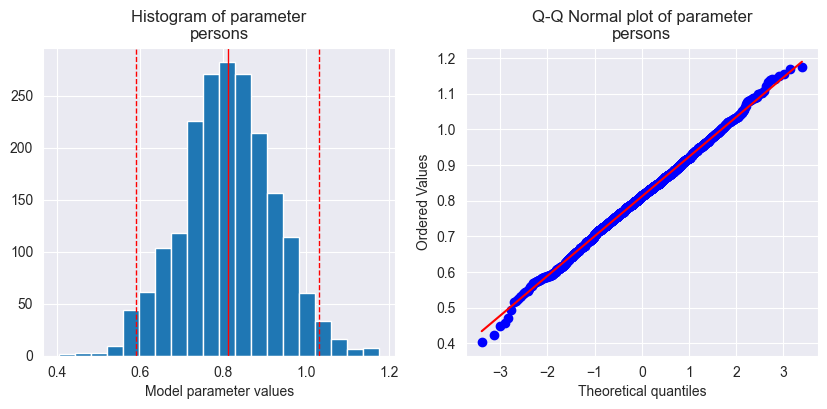

Parameter = child
Mean = -1.5278992530828834
Upper confidence interval = -1.1644921163171695
Lower confidence interval = -1.8749869685926368


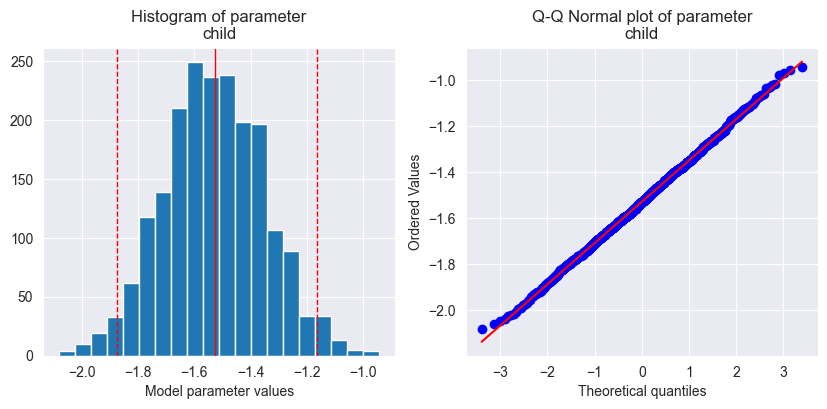

Parameter = camper
Mean = 0.42990417530959046
Upper confidence interval = 0.7463884315062753
Lower confidence interval = 0.1050558387831348


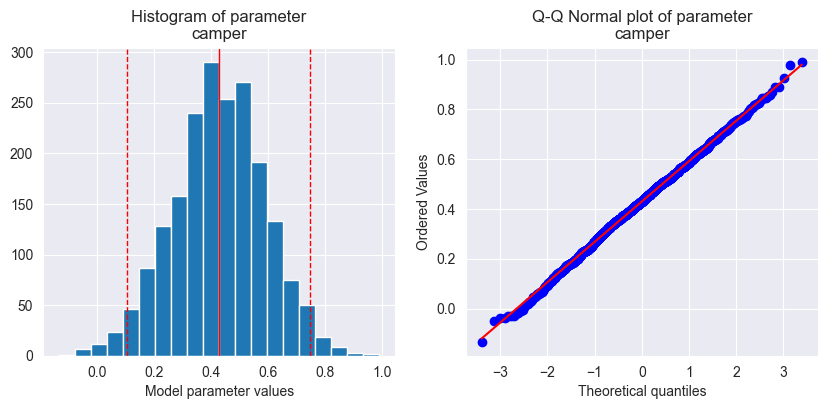

Parameter = alpha
Mean = 1.2657158365006422
Upper confidence interval = 1.8658499714668724
Lower confidence interval = 0.667000503730865


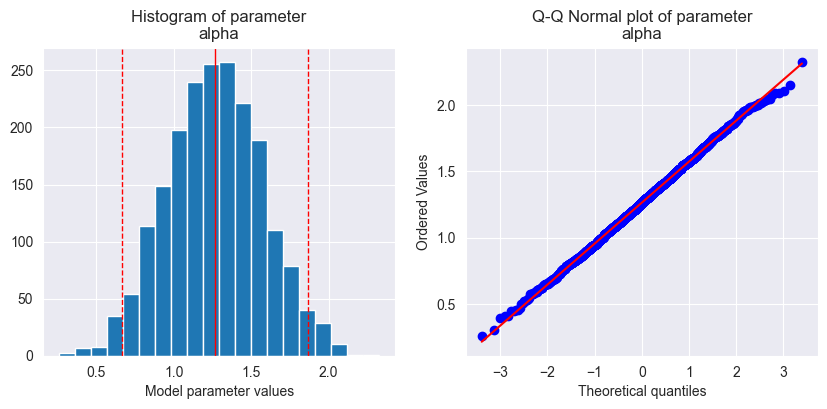

In [137]:
import contextlib
import io

def compute_CI(values, parameter, p=0.05):   
    mean = np.mean(values)
    p = 100 * p / 2.0
    UCI = np.percentile(values, 100 - p)
    LCI = np.percentile(values, p)
    print('Parameter = ' + parameter)
    print(f'Mean = {mean}')
    print(f'Upper confidence interval = {UCI}')
    print(f'Lower confidence interval = {LCI}')
    return(mean, UCI, LCI)

def plot_boot_params(params, parameter='intercept'):
    mean, UCI, LCI = compute_CI(params, parameter)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    ax[0].hist(params, bins=20)
    ax[0].axvline(mean, color='red', linewidth=1)
    ax[0].axvline(UCI, color='red', linewidth=1, linestyle='--')
    ax[0].axvline(LCI, color='red', linewidth=1, linestyle='--')
     
    ax[0].set_title('Histogram of parameter\n' + parameter)
    ax[0].set_xlabel('Model parameter values')
    ## Plot the Q-Q Normal plot
    ss.probplot(params, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of parameter\n' + parameter)
    plt.show()

def resample_regression_negative_binomial(df, n_boots, n_params=2, formula='y ~ x', simulate=False):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace=True)
        ## Compute the OLS model
        boot_model = ZeroInflatedNegativeBinomialP.from_formula(formula=formula, data=boot_sample).fit(maxiter=100, cov_type='HC1')
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params        
        if simulate:
            df['simulation' + str(i)] = boot_model.predict(df)
    return boot_samples, df


with contextlib.redirect_stdout(io.StringIO()):
    poisson_param_boots, simulation = resample_regression_negative_binomial(fish, 2000, n_params=5, formula=formula)
for i,parameter in enumerate(['inflate_const', 'persons','child', 'camper', 'alpha']):  
    plot_boot_params(poisson_param_boots[:,i], parameter=parameter)

> **Exercise 25-3:** Examine these results and answer the following questions:    
> 1. Based on the confidence intervals of the bootstrap resampled values of the model parameters are all these parameters statistically significant?
> 2. Examine the bootstrap distributions of the model parameters. Are they all approximately Normally distributed, and if not which ones and why?
> 3. Consider the odd distribution of parameter(s) with non-Normal distribution. Keep in mind that the bootstrap resampling is done from a small set of observations that contain outliers of the response variable in this case. How can you explain the bootstrap distirbution of the parameter(s) and what is the possible impact on the interpretation of the parameter and the model?  

> **Answers:**
> 1. The confidence intervals show that the parameters are statistically significant since they don't bridge the origin (zero).             
> 2. Most are normally distributed except for the $inflate\_const$. It has a significant negative tail and and appears to be bimodal with a small bump around -13.0.           
> 3. Sampling could produce the appearance of bimodal distributions by heavily weighting certain samples over others. The resampling could give the appearance of the parameter not being normal and something strange is going on. This problem could also go undiscovered by occuring on the climing or declining side of the normal distribution, making the mean seem further to one side or the other incorrectly.        

Another question we should ask, how variable are the predictions of the bootstrap realizations of the model and how well do these values agree with the responses of the observation. To find out execute the code in the cell below to creater 100 realizations of the model.     

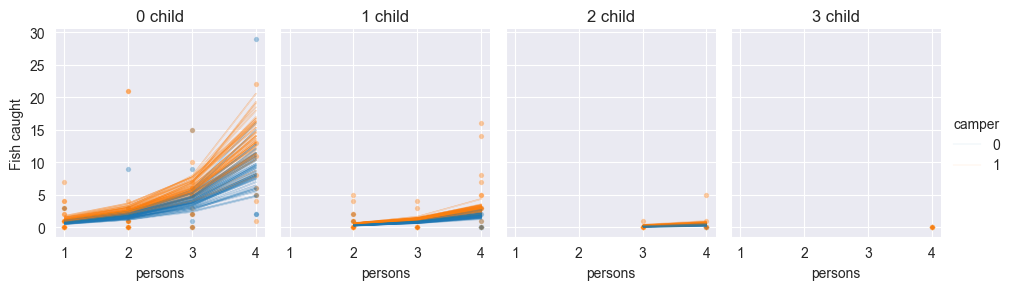

In [138]:
def plot_fish_simulation(df, x, c1, c2, n_simulations, g=None):     
    if g==None:
        g = sns.FacetGrid(df, col=c1, hue=c2, height=5, aspect=0.8);
    for i in range(n_simulations):
        g = g.map(sns.lineplot, x, 'simulation' + str(i), alpha=0.2, linewidth = 0.3)
    for i, ax in enumerate(g.axes.flatten()):
        ax.set_ylabel('Fish caught')
        ax.set_title(str(i) + ' child')
    g.add_legend()
    return g


n_simulations=50
with contextlib.redirect_stdout(io.StringIO()):
    poisson_param_boots, simulation = resample_regression_negative_binomial(fish, n_simulations, n_params=5, formula=formula, simulate=True)

## Add the mean back to the persons column to improve interpretability  
fish['persons'] = fish['persons'] + persons_mean

## Plot the results
g = plot_fish(fish, 'persons', 'child', 'camper', 'count')
plot_fish_simulation(simulation, 'persons', 'child', 'camper', n_simulations, g=g); 

> **Exercise 25-4:** Examine the range of outcomes for from the bootstrap realizations and answer the following questions:
> 1. Describe at least three aspects of the bootstrap model responses thst are consistent with the observed responses.
> 2. What does the dispersion of the responses of the bootstrapped models tell you about the sensitivity of the sensitivity of the model to the data?    

> **Answer:**
> 1. The spread of the simulation fits is greater with lower numbers of children. Less children means a less predictable number of fish caught. The number of outliers is inversely proportional to the number of children on the trip.          
> 2. It appears the sensitivity is high, giving us wild differences in simulations due to trying to get a positive result for all the outliers. More specificity would reduce the dispersion of simulation lines, but skew the lines up or down depending on how it were balanced.           

## Leverage and Cook's Distance

We have just explored a situation where the distribution of the response variable is over-dispursed. But, in the real world there are errors and outliers in data. These errors and outliers can have greater or lesser effect, depending on how extreme they are and their placement with respect to the other data. 

You can imagine a regression line as a lever. Outliers that occur near the ends of the lever will have a greater influence, all other factors being equal. 

One way to measure influence of a data point is **Cook's distance**, introduced by Dennis Cook in 1977. The influence for the ith data point can be computed as:

$$D_i = \frac{\Sigma_{j=1}^n (\hat{Y}_j - \hat{Y}_{j(i)})^2}{n (p+1)\hat{\sigma^2}}$$
where,

\begin{align}
\hat{Y}_{j} &= the\ jth\ prediction\ computed\ with\ all\ observations\\
\hat{Y}_{j(i)} &= the\ jth\ prediction\ computed\ without\ the\ ith\ observation\\
p &= number\ of\ parameters\\
\hat{\sigma^2} &= empirical\ variance\ estimate\ of\ the\ complete\ set\ of\ residuals\\
n &= number\ of\ data\ points
\end{align}

In effect, cooks distance compares the mean squared difference between predicted values with and without a given data point. This calculation is updated excluding each observation one at a time. Thus, Cook's distance is a resampling method. Therefore, computing Cook's distance can be computationally intensive for large datasets. Typically, Cook's distance is measured in units of standard deviation.

A great many methods have been developed to analyze leverage and influence. The Statsmodels packages uses a version of Cook's distance that does not adjust for the number of samples and uses a different DoF correction:    

$$D_i = \frac{\Sigma_{j=1}^n (\hat{Y}_j - \hat{Y}_{j(i)})^2}{p\ \hat{\sigma^2}}$$

Let's make these concepts concrete with some examples. 

### A synthetic example   

Let's start with a simple example using synthetic data. For this example we will create a dataet, fit a regression model, the add an outlier to the ataset and compute a new linear model.     

The code in the cell below does the following:      
- Generates a synthetic dataset with a zero-centered independent variable.     
- Defines and fits an OLS model to the data set and prints a summary.      
- Adds a single outlier to the dataset.      
- Computes a new OLS model with the dataset containing the outlier, and prints a summaruy.    
- Plots the dataset along with the predictions from the models, with and without the outlier.    

Execute this code and examine the result.    

OLS model with no outlier
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     469.5
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           1.97e-26
Time:                        17:56:01   Log-Likelihood:                -64.907
No. Observations:                  50   AIC:                             133.8
Df Residuals:                      48   BIC:                             137.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0111     

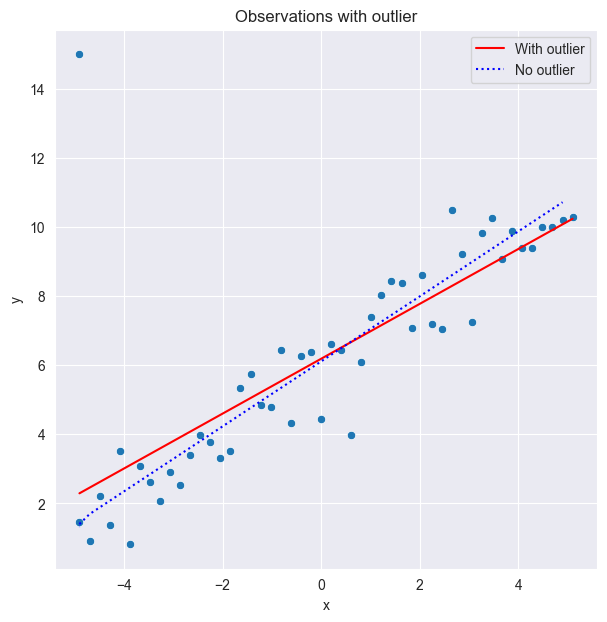

In [139]:
# Paramters of generated data
n_points = 50
x_start, x_end = -5.0, 5.0
y_start, y_end = 0.0, 10.0
y_sd = 1

# Generate data columns
np.random.seed(5666)
x_data = np.linspace(x_start, x_end, n_points) # The x values
y_error = np.random.normal(loc=0, scale=y_sd, size=n_points) # The Normally distributed noise
y_data = np.linspace(y_start, y_end, n_points) + y_error + 1.0 # The y values including an intercept

# Put data in a dataframe
sim_data = pd.DataFrame({'x':x_data, 'y':y_data})

# OLS model and prediciton with no outlier
ols_model_no_outlier = smf.ols(formula = 'y ~ x', data=sim_data).fit()
print('OLS model with no outlier')
print(ols_model_no_outlier.summary())


## Add single outlier to dataframe
outliers = pd.DataFrame({'x':[-5.0], 'y':[15], 'predicted':[0.0], 'resids':[0.0]})
sim_data_outlier = pd.concat([outliers,sim_data]).reset_index().drop('index', axis=1)

## Compute OLS model

## Define the regresson model, fit it to the data and predict 
sim_data_outlier['x'] = np.subtract(sim_data_outlier.loc[:,'x'], np.mean(sim_data_outlier.loc[:,'x']))
ols_model = smf.ols(formula = 'y ~ x', data=sim_data_outlier).fit()
sim_data_outlier['predicted_outlier'] = ols_model.predict(sim_data_outlier.x)
sim_data_outlier['predicted_no_outlier'] = ols_model_no_outlier.predict(sim_data.x)

fig, ax = plt.subplots(figsize=(7,7))
ax = sns.scatterplot(x='x', y='y', data=sim_data_outlier, ax=ax)
ax = sns.lineplot(x='x', y='predicted_outlier', data=sim_data_outlier, color='red', label='With outlier')
ax = sns.lineplot(x='x', y='predicted_no_outlier', data=sim_data_outlier, color='blue',  linestyle = 'dotted', label='No outlier')
_=ax.set_title('Observations with outlier');
plt.legend();
print('\n\n\nOLS model with outlier')
print(ols_model.summary())

Notice the following about the results of the two models.       
1. Notice that the intercept of the two models are quite similar. However, there is a noticeable change slope coefficient. However, the change in slope is just within the confidence intervals cannot be considered significant. Still, the outlier has introduced a bias in the model results.        
2. The OLS regression line computed without the outlier shows a fit to the bulk of the data. Notice how the slope of the regression line changes because of the outlier, and does not seem to represent the buld of the data well.
3. These change in the models is an example of effect of a **high leverage outlier**.    

You can create an **influence plot**, which shows the influence and leverage of the observations vs. the standardized residuals. The [statsmodels.graphics.regressionplots.influence_plot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.influence_plot.html) displays Cook's distance as a measure of influence. Execute the code in the cell below to display the influence plot for the OLS model of the data with the outlier. 

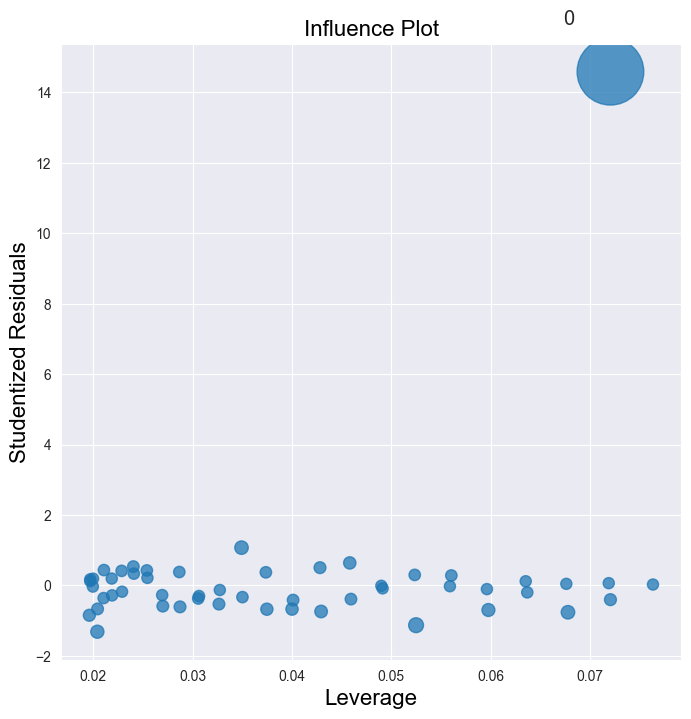

In [140]:
fig,ax = plt.subplots(figsize=(8,8))
_=influence_plot(ols_model, ax=ax)

The resulting plot shows variance standardized residuals on the vertical axis vs. Cook's distance leverage on the horizontal axis. The size of the marker is indicates the influence of the observation on the model. There is one observation with a large residual, the outlier or point 0, which has significant influence on the regression model. This observation has a large standardized residual and significant leverage. Other observations have high leverage, but small residuals. 

Stats models also provides the [statsmodels.graphics.regressionplots.plot_regress_exog](https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_regress_exog.html) plotting method which displays a series of **partial regression plots**. A partial regression plot displays various measures of the regression model fit vs. a selected exogenous variable or feature. Execute the code in the cell below to see an example of these plots and examine the results.

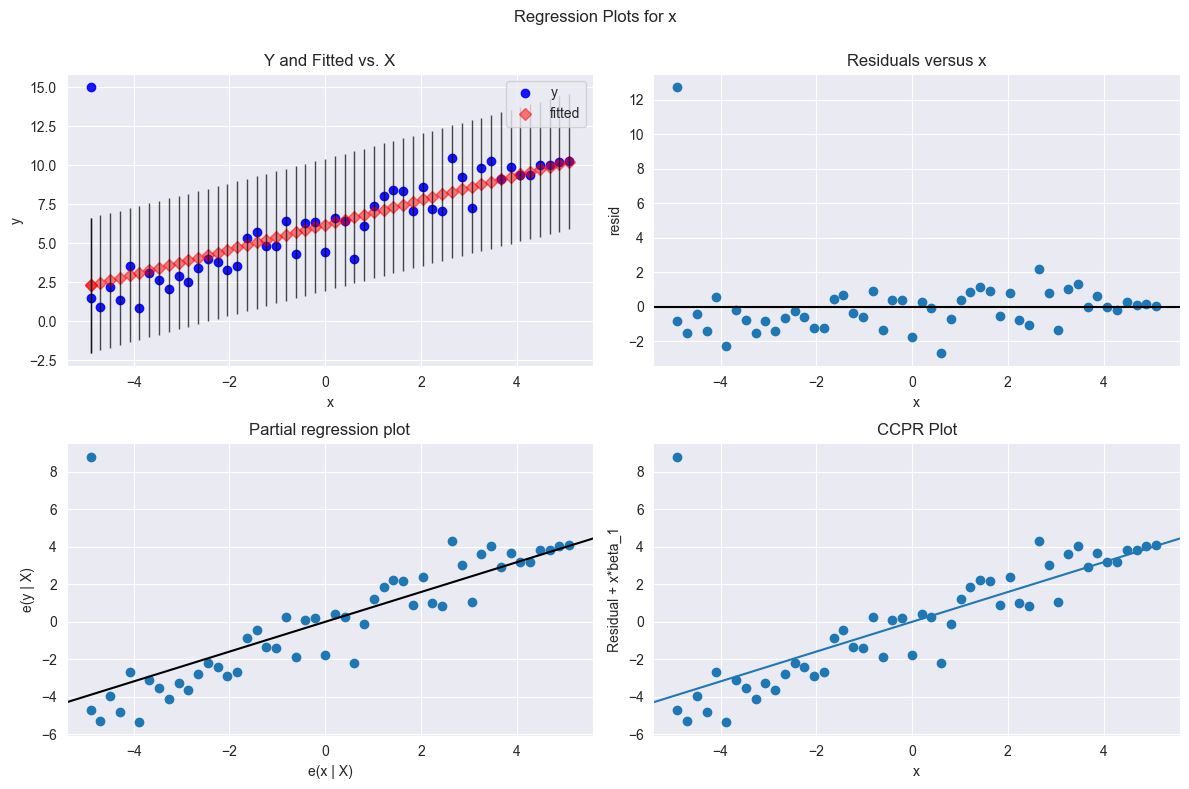

In [141]:
fig = plt.figure(figsize=(12, 8))
_=plot_regress_exog(ols_model, 'x', fig=fig)

These plots provide several views of the fit of the model to the observations.     
1, A plot of the fitted values vs the observations.     
2. A residual plot, clearly shoing the outlier.     
2. Plots shoing the regression line and observations and the residuals with fitted values on the CCPR plot.       

Next, execute the code in the cell below to display the characteristics of the distribution of the residuals.  

The mean of the residuals = -0.000  RMSE = 2.045


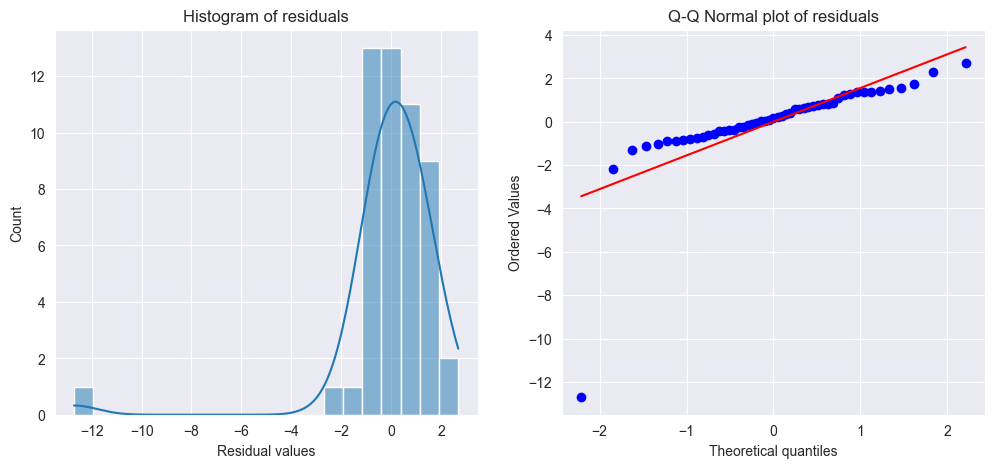

In [142]:
sim_data_outlier['resids'] = np.subtract(sim_data_outlier.predicted_outlier, sim_data_outlier.y)

## Your code below
print('The mean of the residuals = {0:4.3f}  RMSE = {1:4.3f}'.format(np.mean(sim_data_outlier.resids), np.std(sim_data_outlier.resids)))

plot_resid_dist(sim_data_outlier.resids)

With the exception of the outlier, these residuals are close to Normally distributed. The outlier clearly has an effect on the residuals.   

### Another Example

Let's try another example with a small real dataset. Stack loss is an undesireable effect in an industrial chemical process. Understanding the dependence of stack loss on the other variables could help improve the chemical process.  

To start, execute the code in the cell below to load the dataset and display the data frame. 

In [143]:
StackLoss = sm.datasets.stackloss.load_pandas().data    #sm.datasets.get_rdataset("stackloss")
StackLoss.columns = ['Stackloss','Airflow','Watertemp','Acidconc']

for col in ['Airflow','Watertemp','Acidconc']:
    StackLoss.loc[:,col] = StackLoss.loc[:,col] - StackLoss.loc[:,col].mean()

StackLoss

,Stackloss,Airflow,Watertemp,Acidconc
0,42.0,19.571429,5.904762,2.714286
1,37.0,19.571429,5.904762,1.714286
2,37.0,14.571429,3.904762,3.714286
3,28.0,1.571429,2.904762,0.714286
4,18.0,1.571429,0.904762,0.714286
5,18.0,1.571429,1.904762,0.714286
6,19.0,1.571429,2.904762,6.714286
7,20.0,1.571429,2.904762,6.714286
8,15.0,-2.428571,1.904762,0.714286
9,14.0,-2.428571,-3.095238,-6.285714


The dependent or response variable is `Stackloss`. There are three independent varaibles `Airflow`, `Watertemp`, and `Acidconc'.   

To get a better feeling for this dataset, execute the code in the cell below to display a scatter plot matrix of the observations.   

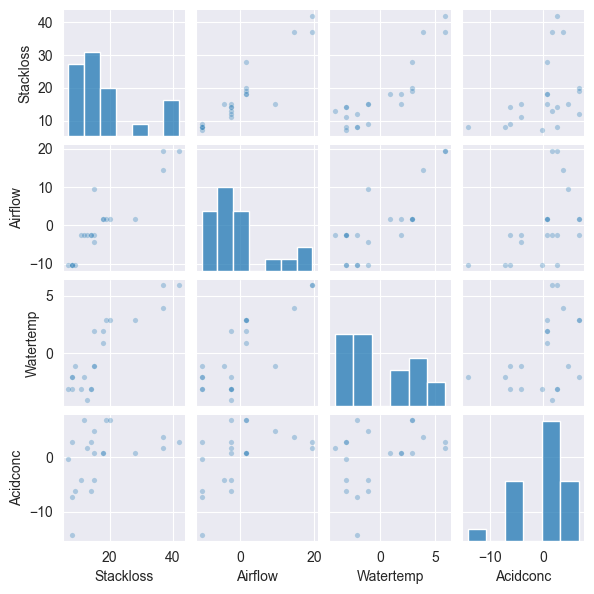

In [144]:
sns.pairplot(StackLoss, height = 1.5, plot_kws={"s": 15, 'alpha':0.3});

> **Exercise 25-5:** We can try a more complex model for the price of the autos by introducing an additional explanatory variable. Additionally, we introduce an interaction term between the two explanatory variables. The interaction term being the product of the two variables. To perform this analysis do the following steps:     
> 1. Define a model named `stackloss_OLS` with model formula `Stackloss ~ Airflow + Watertemp + Acidconc`.   
> 2.Print the summary of the model
> 3. Compute the predicted values and store them in the `predicted` column of the data frame.   
> 4. Compute the residuals and store them in the `resids` column of the data frame.   
> 5. Print the mean and the RMSE of the residuals.    
> 6. Display the distribution plots of the residuals.   
> 7. Display a plot of residuals vs. predicted values.   
> 8. Finally, display the influence plot for the residuals.

                            OLS Regression Results                            
Dep. Variable:              Stackloss   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     59.90
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           3.02e-09
Time:                        17:56:05   Log-Likelihood:                -52.288
No. Observations:                  21   AIC:                             112.6
Df Residuals:                      17   BIC:                             116.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.5238      0.708     24.760      0.0

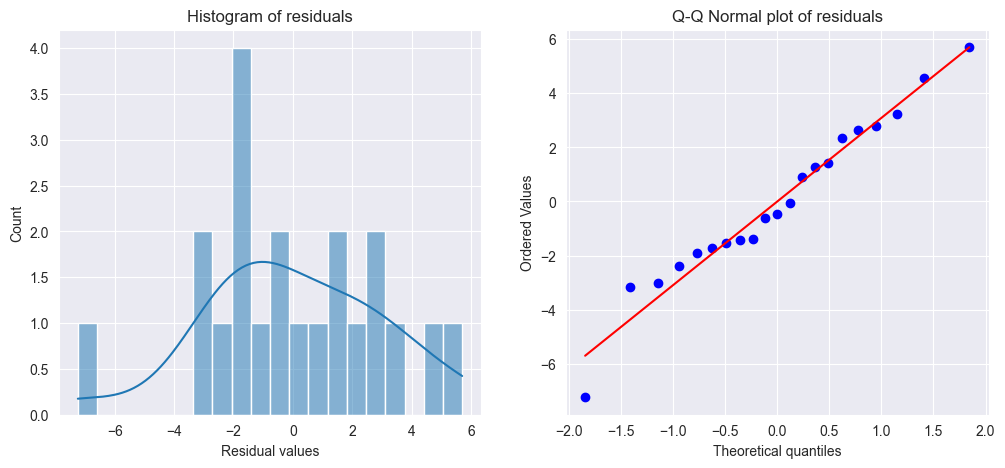

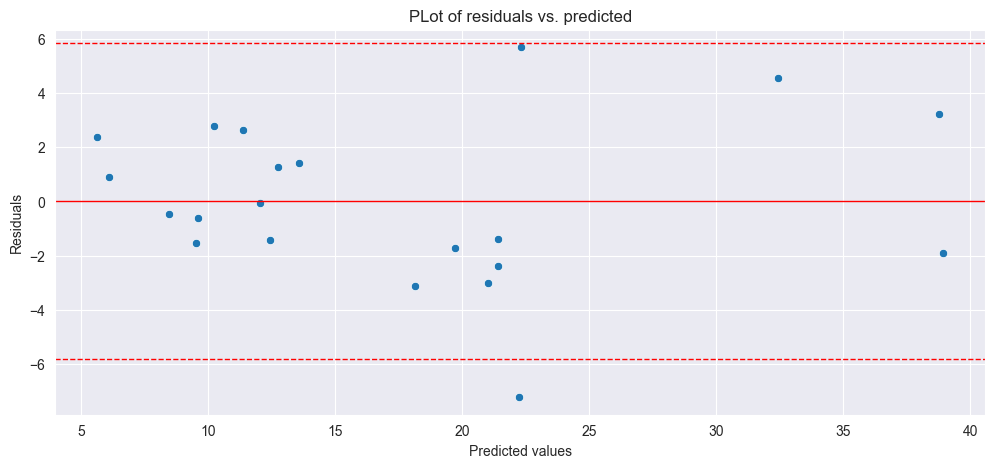

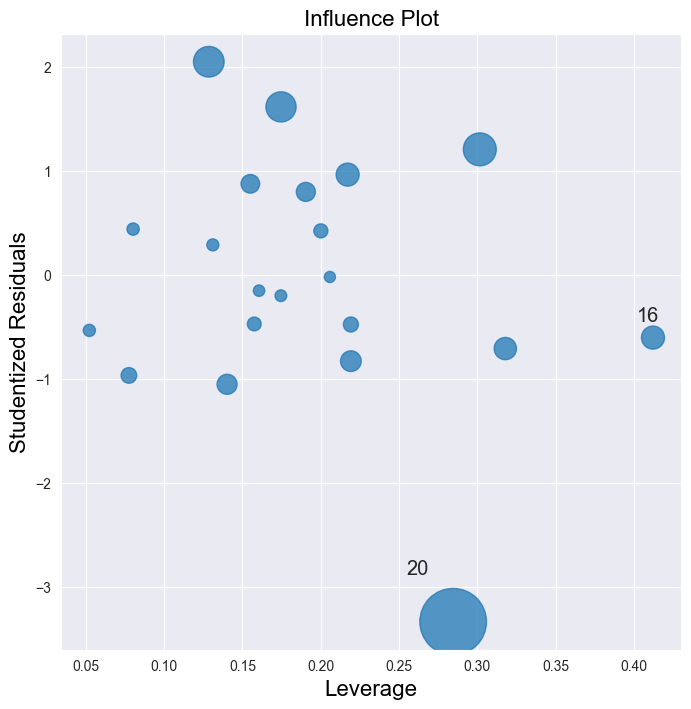

In [145]:
## Put your code below  
# > 1. Define a model named `stackloss_OLS` with model formula `Stackloss ~ Airflow + Watertemp + Acidconc`.
formula = "Stackloss ~ Airflow + Watertemp + Acidconc"
stackloss_OLS = smf.ols(data=StackLoss, formula=formula).fit()
# > 2.Print the summary of the model
print(stackloss_OLS.summary())
# > 3. Compute the predicted values and store them in the `predicted` column of the data frame.
StackLoss['predicted'] = stackloss_OLS.predict(StackLoss)
# > 4. Compute the residuals and store them in the `resids` column of the data frame.
StackLoss['resids'] = stackloss_OLS.resid
# > 5. Print the mean and the RMSE of the residuals.
print('Mean of the residuals = ' + str(round(np.mean(StackLoss['resids']), 3)))
print('RMSE of the residuals = ' + str(round(np.std(StackLoss['resids']), 3)))
# > 6. Display the distribution plots of the residuals.
plot_resid_dist(StackLoss.resids)
# > 7. Display a plot of residuals vs. predicted values.
residual_plot(StackLoss)
ax.set_title("Residuals vs Predictions")
# > 8. Finally, display the influence plot for the residuals.
fig,ax = plt.subplots(figsize=(8,8))
influence_plot(stackloss_OLS, ax=ax);








> 8. Execute the code in the cell below that creates a scatterplot matrix highlighting the high influence and high leverage data points.  

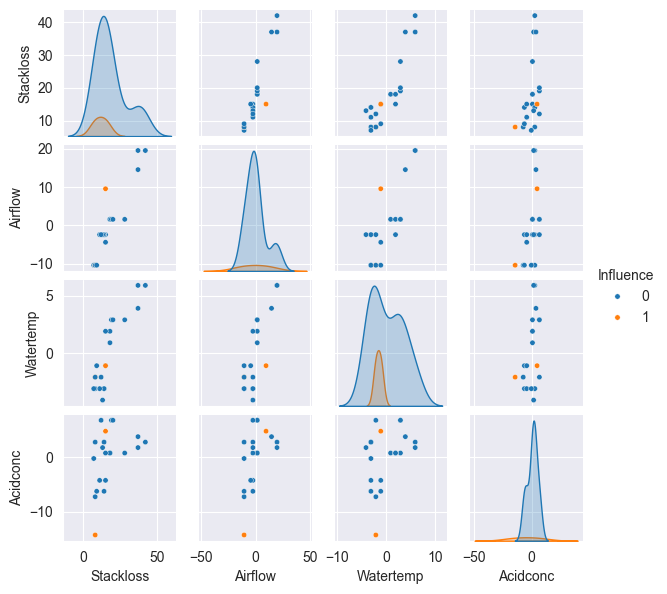

In [146]:
StackLoss['Influence'] = [0]*len(StackLoss)
StackLoss.loc[[16,20],'Influence'] = 1

sns.pairplot(StackLoss.loc[:,['Stackloss','Airflow','Watertemp','Acidconc','Influence']], hue='Influence', height = 1.5, plot_kws={"s": 15});

> Now answer these questions:    
> 1. Examine the summary of the coefficient values. Are all the model coefficient significant and how can you tell?        
> 2. Are the Residuals approximately Normal and homoscendasitc?           
> 3. Examine the leverage and residuals on the influence plot. Are there any high-leverage residuals shown on this plot?
> 4. Examine the scatter plot matrix showing the high influence and high leverage points along with the other observations. Does at least one of these points stand out as an outlier, and why?

> **Answers:**     
> 1. All the coefficient values are significant except for AcidConc since its p value is too high and its confidence interval includes zero.       
> 2. No, the residuals do not appear Normal or homoscedastic.        
> 3.  Yes there are some high leverage points on the plot. These are points 20 and 16 in order of greater influence first.      
> 4.  Yes, there appears to be an outlier in Watertemp that you can see in all related plots and it shows a large spike in the high influence chart at the matrix intersection of the parameter. Stackloss seems to have a small one as well.          

## Robust Regression Algorithms  

So far we have only been working with linear ordinary least squares (OLS). The response of a linear model to an observation value is linear, by definition. Consequently, there will be a large proportionate response to any outlier. This effect can strongly influence the training of linear models, as you have seen from the OLS model previously computed and evaluated. This effect is defined by the **influence function**.         

**Robust regression** models limit the influence of outliers when training a model. There have been many types of robust regression models that been developed over many years. These models are based on different types of influence functions.    

There are trade-offs with using robust regression. OLS models are generally **unbiased minimum variance estimators**. However, by limiting the influence function a robust model is no longer unbiased or minimum variance. In technical terms we say that the robust models are not **efficient**. 

Given the aforementioned trade-off, one seeks to design robust estimators with the following properties:   
1. The estimator can be linear, and therefore unbiased, near the expected value
2. Limit the influence of outliers by using a nonlinear influence function beyond the linear region.   
3. The linear response near the expected value allows use of MLE methods. 

The median estimator is a well-known to be robust, but is not idea since it does not have all of these properties. This situation can be understood by examining the figure below.   

<img src="../images/MeanMedianInfluence.png" alt="Drawing" style="width:350px; height:250px"/>
<center>Influence functions of linear and median estimators: Credit, Hampel, et.al. Robust Statistics, 1986</center>  

Comparing these influence functions we can see: 
1. The influence function of the linear model is labeled T=mean. This function is linear and unbounded, meaning that the influence of an extreme outlier is also unbounded. The linear behavior and continuous derivatives of the influence function mean that this estimator is both an efficient and minimum variance MLE.   
2. The median estimator is far from linear and has discontinuous derivatives about the estimated value. These properties lead to high variance from median estimates.  

For a state of the art discussion of robust estimators see [Maronna, et.al., Robust Statistics, Theory and Methods (with R), Second Edition, 2019, Wiley](https://www.wiley.com/en-us/Robust+Statistics:+Theory+and+Methods+(with+R),+2nd+Edition-p-9781119214687).  

### Alpha-trimming       

A simple robust estimator is called **alpha trimming**. The idea is to simply delete the observations with the largest positive and negative residuals. OLS regression is trained using the remaining values.       

The fraction of the observations removed in this manner is known as $\alpha$. Typically, $\alpha/2$ of the positive and $\alpha/2$ of the negative residuals are deleted. Typical value of $\alpha$ are 10%, 20% or 30%, but most any value less than 50% can be used.     

The larger the value of $\alpha$ the more robust the estimator is. We say that the larger value of $\alpha$ gives the estimator a higher **breakdown point**. The breakdown point is equal to  $\alpha$ for this estimator.        

Examples of influence functions for alpha trimmed estimators are shown in the figure below.  

<img src="../images/AlphaTrimming.png" alt="Drawing" style="width:350px; height:250px"/>
<center>Influence functions of linear and alpha-trimmed estimators: Credit, Hampel, et.al. Robust Statistics, 1986</center>    
    
Examine the figure above and notice the following.     
1. As stated before, the influence function of the linear model, labeled $\bar{X}$, is linear and unbounded.   
2. The influence function of alpha-trimmed estimators are locally linear, but then bounded. This bounding limits the influence of outliers to a constant. The slopes of the linear portion of the alpha-trimmed estimators are not the same as the linear estimator. The combination of the increased slope and bounding of the influence function results in bias and the estimator no longer being minimum variance. Estimators with higher values of alpha have more bias.            

### Huber estimators    

Peter Huber (1964, 1984) proposed an estimator that possess the minimum variance properties near the expected value but limits the influence of outliers to a constant. In contrast to alpha-trimming, the Huber estimator does not discard observations, but rather places a hard limit on their influence. The influence function of the Huber estimator can be seen in the figure below.     

<img src="../images/Huber.png" alt="Drawing" style="width:350px; height:250px"/>
<center>Influence function of Huber estimator: Credit, Hampel, et.al. Robust Statistics, 1986</center>  

Examining the above figure, we can see some key properties of the Huber estimator:   
1. The influence function is linear near the mean but constant away from the mean.   
   - The **hinge point** is at $\pm t * MAD$, where $MAD =$ **median absolute deviation**.    
   - Robustness and bias increases as $t$ decreases. 
2. Huber estimator is low bias.      
   - The estimator is unbiased for samples near the point estimate.   
   - There is constant influence away from the point estimate, for outliers beyond the hinge points, $\pm t$.   

### M-estimators   

A large family of robust estimators are known as **M-estimators**. M-estimators attempt to improve on the properties of the Huber estimator by slowly decreasing the influence of extreme outliers toward 0. Whereas a Huber estimator has constant influence beyond the hinge point, an M-estimator will down-weight extreme outliers. Quite a number of M-estimators have been proposed.    

All M-estimators require somewhat complicated selection of hyperparameter values. The Huber estimator has a single hyperparameter, the hinge point. M-estimators often have two or more hyperparameters.   

A fairly simple example of an M-estimator is the Tukey biweight estimator (Tukey 1981). The influence function of the biweight estimator can be seen in the figure below.   

<img src="../images/TukeysBiweight.png" alt="Drawing" style="width:400px; height:250px"/>
<center>Influence function of the Tukey biweight estimator: Credit, Hampel, et.al. Robust Statistics, 1986</center>  



The biweight estimator uses a smooth influence function that is locally linear around the point estimate, eventually tapering to 0. The point at which the biweight becomes zero is the single hyperparameter, $r$. Both Robustness and bias increase with decreasing $r$.  

> **Exercise 25-6:** You will now create and evaluate a robust regression model for the `sim_data_outlier` dataset by the following steps:       
> 1. Define a robust regression model using [statsmodels.formula.api.rlm](https://www.statsmodels.org/dev/generated/statsmodels.formula.api.rlm.html) using the formula `"y ~ x"`,with the argument `M=sm.robust.norms.HuberT()` and name your model `ols_model_huber`.  
> 2. Print the summary of the model.     
> 3. Compute the predictions and save them in a `predicted_huber` column of the data frame.    
> 4. Compute the residuals and save them in a `residuals_huber` column of the data frame.   
> 5. Display the distribution plots of the residuals.        
> 6. Plot the residuals vs. the predicted values. 
> 7. Display a plot with the following:    
>     - A scatter plot of the x-y values of the `sim_data_outlier` dataset.     
>     - A line showing the predicted values from the robust regression.    
>     - A line, using a different line type and color, showing the predicted values from the OLS model, computed with the outlier in the introduction to the synthetic dataset.    
>     - Include a legend on your plot.   

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   51
Model:                            RLM   Df Residuals:                       49
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 Nov 2024                                         
Time:                        17:56:07                                         
No. Iterations:                    16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9711      0.131     45.553      0.0

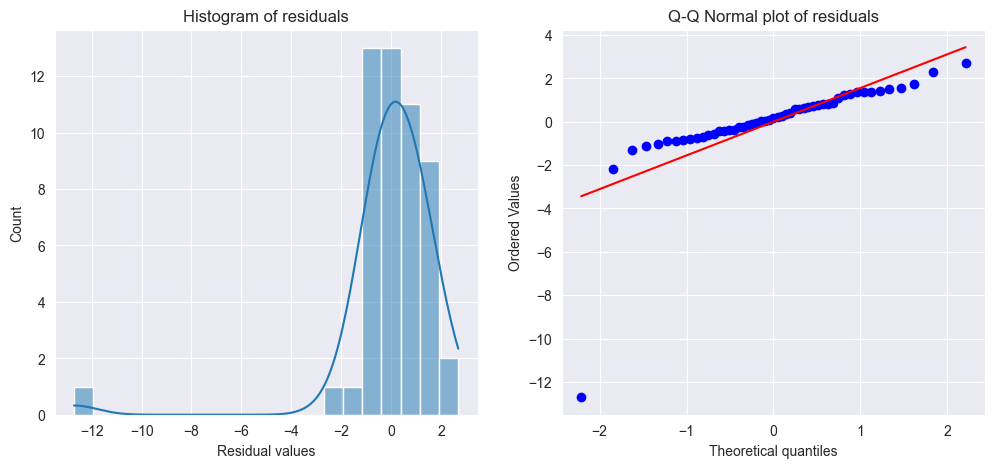

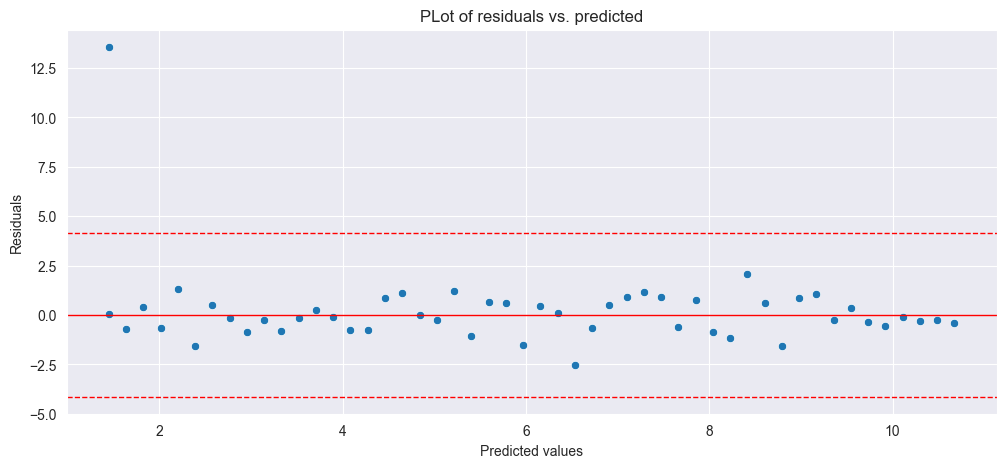

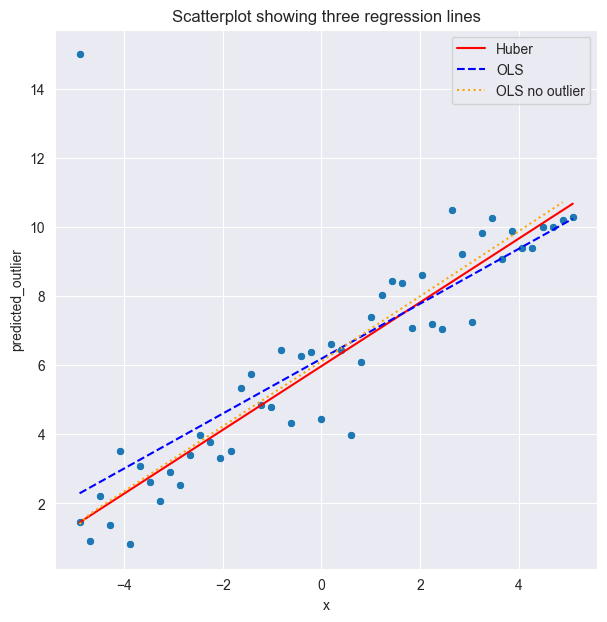

In [147]:
## Put your code below
# > 1. Define a robust regression model using [statsmodels.formula.api.rlm](https://www.statsmodels.org/dev/generated/statsmodels.formula.api.rlm.html) using the formula `"y ~ x"`,with the argument `M=sm.robust.norms.HuberT()` and name your model `ols_model_huber`.
formula = "y ~ x"
M = sm.robust.norms.HuberT()
ols_model_huber = smf.rlm(formula=formula, data=sim_data_outlier, M=M).fit()
# > 2. Print the summary of the model.
print(ols_model_huber.summary())
# > 3. Compute the predictions and save them in a `predicted_huber` column of the data frame.
sim_data_outlier['predicted_huber'] = ols_model_huber.predict(sim_data_outlier)
# > 4. Compute the residuals and save them in a `residuals_huber` column of the data frame.
sim_data_outlier['residuals_huber'] = ols_model_huber.resid
# > 5. Display the distribution plots of the residuals.
plot_resid_dist(sim_data_outlier.resids)
# > 6. Plot the residuals vs. the predicted values.
residual_plot(sim_data_outlier,predicted='predicted_huber', resids='residuals_huber')
# > 7. Display a plot with the following:
#     >     - A scatter plot of the x-y values of the `sim_data_outlier` dataset.
# >     - A line showing the predicted values from the robust regression.
# >     - A line, using a different line type and color, showing the predicted values from the OLS model, computed with the outlier in the introduction to the synthetic dataset.
# >     - Include a legend on your plot.
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(sim_data_outlier.x, sim_data_outlier.predicted_huber, color='red', label='Huber')
ax = sns.lineplot(x='x', y='predicted_outlier', data=sim_data_outlier, color='blue', linestyle = 'dashed', label='OLS')
ax = sns.lineplot(x='x', y='predicted_no_outlier', data=sim_data_outlier, color='orange', linestyle = 'dotted', label='OLS no outlier')
sns.scatterplot(x='x', y='y', data=sim_data_outlier, ax=ax)
ax.set_title('Scatterplot showing three regression lines')
plt.legend()
plt.show()

> Answer the following questions:      
> 1. Are there significant differences between the coefficients of the Huber and OLS model and which ones are closer to the OLS values computed without the outlier?          
> 2. Notice the CIs for the Huber and OLS model computed with the outlier. What systematic difference can you see and what does this tell you about the influence of the outlier?
> 3. Are the residuals close to Normally distributed and homoscedastic, except the outlier?         
> 4. From the scatter plot, does in appear that the Huber estimator model fits the bulk of the data better?     

> **Answers:**       
> 1. There are differences in the coefficients, but it's not a huge difference. The Huber coefficients are closer to the non-outlier model coefficients though.        
> 2. The CI's for the Huber models are tighter than they ones for the OLS model with the outlier. This shows that the outlier widens the CI, reducing the accuracy of the model coefficients.            
> 3. Yes, the residuals are close to normal and homoscedastic except the outlier.         
> 4. Yes, the Huber estimator models seems to fit the bulk of the data better.          

### Another example

We will return to the stack loss data and apply a robust model. Comparing the robust model to the OLS model can provide some insioght on the effect of limiting the influence of outliers.      

> **Exercise 25-7:** You will now create and evaluate a robust regression model for the `Stackloss` dataset by the following steps:       
> 1. Define a robust regression model using [statsmodels.formula.api.rlm](https://www.statsmodels.org/dev/generated/statsmodels.formula.api.rlm.html) using the formula `"Stackloss ~ Airflow + Watertemp + Acidconc"`,with the argument `M=sm.robust.norms.HuberT()` and name your model `stackloss_huber`.  
> 2. Print the summary of the model.     
> 3. Compute the predictions and save them in a `predicted_huber` column of the data frame.    
> 4. Compute the residuals and save them in a `residuals_huber` column of the data frame.   
> 5. Display the distribution plots of the residuals.        
> 6. Plot the residuals vs. the predicted values. 

                    Robust linear Model Regression Results                    
Dep. Variable:              Stackloss   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 Nov 2024                                         
Time:                        17:56:08                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.5962      0.583     30.204      0.0

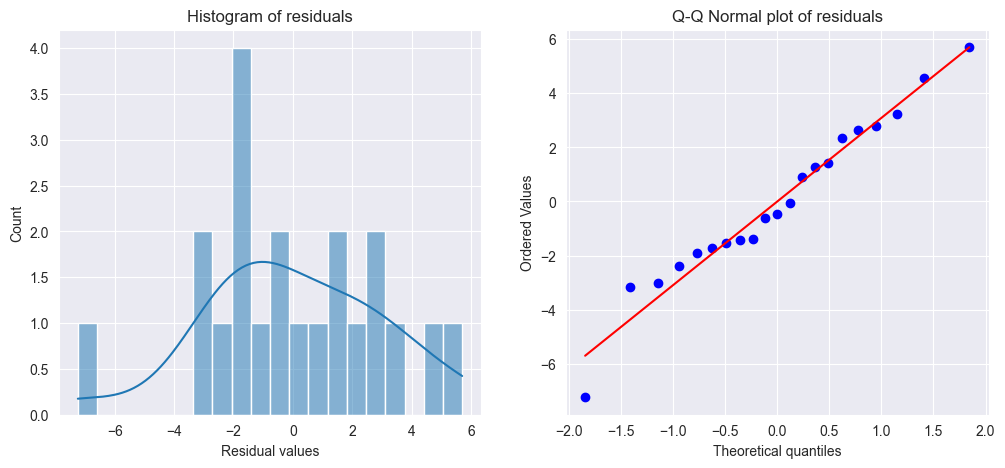

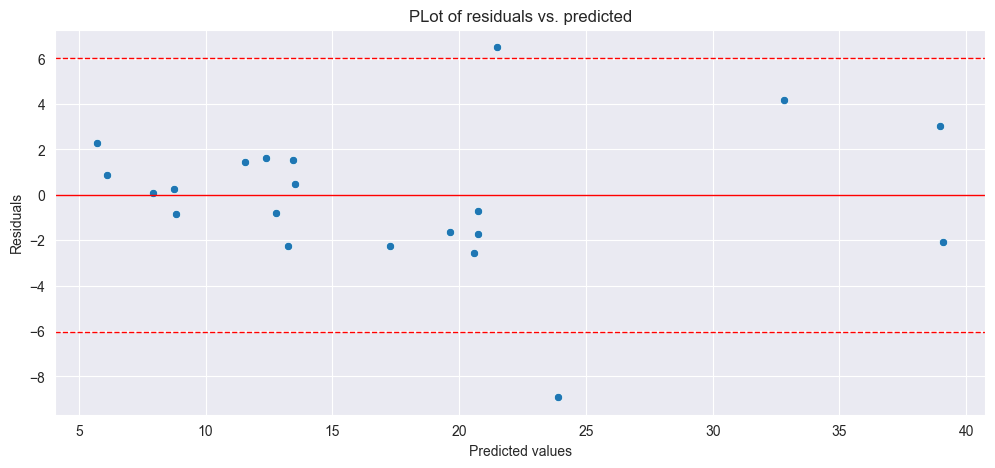

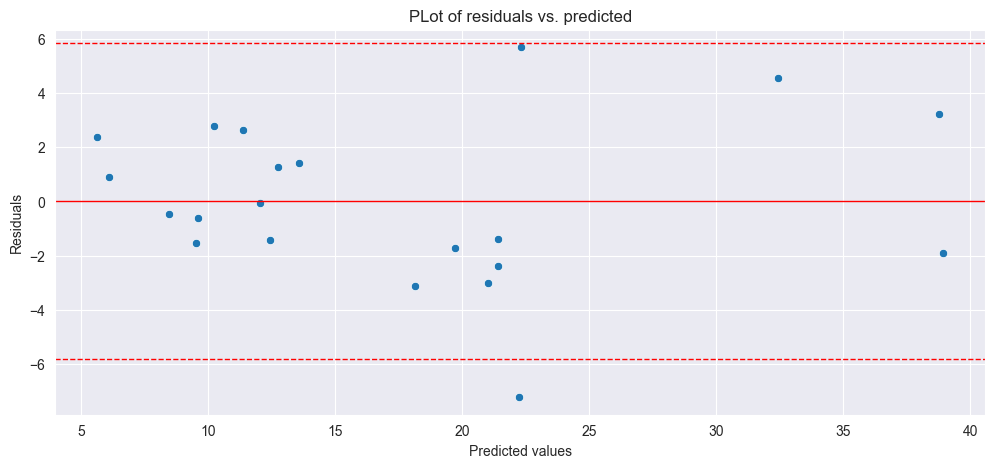

In [148]:
## Put your code below   
# > 1. Define a robust regression model using [statsmodels.formula.api.rlm](https://www.statsmodels.org/dev/generated/statsmodels.formula.api.rlm.html) using the formula `"Stackloss ~ Airflow + Watertemp + Acidconc"`,with the argument `M=sm.robust.norms.HuberT()` and name your model `stackloss_huber`.
formula = "Stackloss ~ Airflow + Watertemp + Acidconc"
M = sm.robust.norms.HuberT()
stackloss_huber = smf.rlm(formula=formula, data=StackLoss, M=M).fit()
# > 2. Print the summary of the model.
print(stackloss_huber.summary())
# > 3. Compute the predictions and save them in a `predicted_huber` column of the data frame.
StackLoss['predicted_huber'] = stackloss_huber.predict(StackLoss)
# > 4. Compute the residuals and save them in a `residuals_huber` column of the data frame.
StackLoss['residuals_huber'] = stackloss_huber.resid
# > 5. Display the distribution plots of the residuals.
plot_resid_dist(StackLoss.resids)
# > 6. Plot the residuals vs. the predicted values.
residual_plot(StackLoss, predicted='predicted_huber', resids='residuals_huber')
residual_plot(StackLoss)

> Examine the results and compare them to the results from the OLS model and answer the following questions:
> 1. Compare the model coefficients computed for the Huber and OLS models. Are there noticeable differences in the coefficeint values, and are the differences statisticallty significant given the confidence intervals?     
> 2. Compare the width of the confidence intervals between the Huber and OLS models. What difference can you identify and how can you explain them?
> 3. What differnce in the distribution of the residuals can you see between the Huber and OLS models?  

> **Answers:**
> 1. There are noticeable differences in the coefficient values, but their within each other's CI's.           
> 2. The CI's are wider in general, which makes sense with the inclusion of the outlier in the former OLS model.            
> 3. It appears that the Huber residuals closer to zero got closer to zero, but residuals further out got pushed further out, like it magnified their adherence or outlier status.       

As a final step, we can display the predictions for both models along with the observations.   

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/121050381.py:3: SyntaxWarning: invalid escape sequence '\c'
  sns.scatterplot(data=StackLoss, x=col, y='Stackloss', ax=ax_i, color='black', alpha=0.3, s=25, marker="$\circ$", label='Stackloss')
/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_40676/121050381.py:5: SyntaxWarning: invalid escape sequence '\c'
  sns.scatterplot(data=StackLoss, x=col, y='predicted_huber', ax=ax_i, color='green', alpha=0.3, marker="$\circ$", s=15, label='Huber')


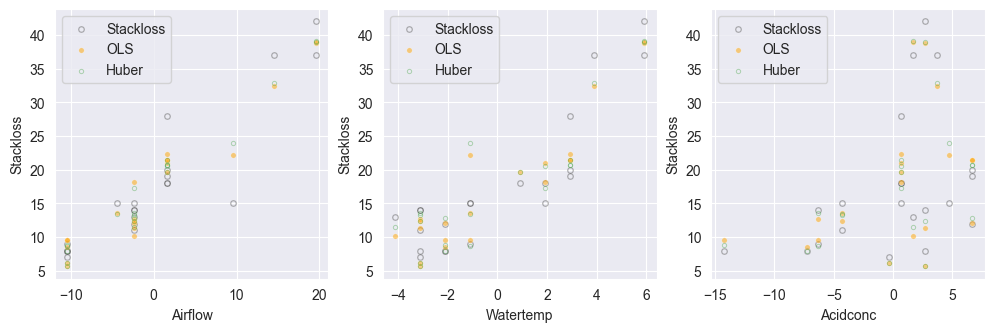

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))
for col, ax_i in zip(['Airflow','Watertemp', 'Acidconc'], ax):
    sns.scatterplot(data=StackLoss, x=col, y='Stackloss', ax=ax_i, color='black', alpha=0.3, s=25, marker="$\circ$", label='Stackloss')
    sns.scatterplot(data=StackLoss, x=col, y='predicted', ax=ax_i, color='orange', alpha=0.5, s=15, label='OLS')
    sns.scatterplot(data=StackLoss, x=col, y='predicted_huber', ax=ax_i, color='green', alpha=0.3, marker="$\circ$", s=15, label='Huber')
    ax_i.legend()

Notice that many of the predictions for both models are close to the observed values in the Stackloss dataset. There does seem to be a slight increase in the dispersion of the predictions for the OLS model with respect to the observatons.  

#### Copyright 2022, 2023, 2024, Stephen F Elston. All right reserved. 